# **1. IMPORT LIBRARY**

---



In [1]:
# --- Cell 1 ---
!python --version

Python 3.11.12


In [2]:
# --- Cell 2 ---
!pip install gensim scikit-learn pandas nltk Sastrawi tensorflow

In [3]:
# --- Cell 3 Library imports ---
import re
import os
import pickle
import json
import logging
import random
from datetime import datetime
import warnings
from typing import Dict, List, Any

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Sastrawi for Indonesian text processing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Gensim for word embedding
import gensim
from gensim.models import FastText, KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec

# TensorFlow/Keras for LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.metrics import RootMeanSquaredError, R2Score
from tensorflow.keras.optimizers import Adam

# Scikit-learn for utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Collections for defaultdict
from collections import defaultdict
import math

In [4]:
# --- Cell 4 ---
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("Gensim version:", gensim.__version__)

NumPy version: 1.26.4
TensorFlow version: 2.18.0
Pandas version: 2.2.2
Gensim version: 4.3.3


In [5]:
# --- Cell 5 ---
drive.mount('/content/drive')

# --- AWAL PENAMBAHAN KODE UNTUK STRUKTUR FOLDER ---
BASE_PROJECT_DIR = '/content/drive/MyDrive/Model/' # Sesuai struktur yang Anda berikan

# Definisikan path-path utama lainnya berdasarkan BASE_PROJECT_DIR
DATASET_DIR = os.path.join(BASE_PROJECT_DIR, '01_Dataset/')
INPUT_JAWABAN_TXT_DIR = os.path.join(DATASET_DIR, 'Input_Jawaban_TXT/') # Untuk nanti jika ada input .txt
PREPROCESSING_DIR = os.path.join(BASE_PROJECT_DIR, '02_Preprocessing_Artifacts/')
EMBEDDING_DIR = os.path.join(BASE_PROJECT_DIR, '03_Word_Embeddings/')
LSTM_MODEL_DIR = os.path.join(BASE_PROJECT_DIR, '04_LSTM_Model/')
LOGS_DIR = os.path.join(BASE_PROJECT_DIR, '05_Training_Logs/')

# Path spesifik untuk subfolder embedding
PRETRAINED_EMBEDDING_DIR = os.path.join(EMBEDDING_DIR, 'Pretrained/')
FINE_TUNED_EMBEDDING_DIR = os.path.join(EMBEDDING_DIR, 'Fine_Tuned/')
EMBEDDING_BEST_KV_SUBDIR = os.path.join(FINE_TUNED_EMBEDDING_DIR, 'embedding_best_kv/')
EMBEDDING_FINAL_MODEL_SUBDIR = os.path.join(FINE_TUNED_EMBEDDING_DIR, 'embedding_final_model/')

# Membuat direktori-direktori ini jika belum ada
directories_to_create = [
    BASE_PROJECT_DIR, DATASET_DIR, INPUT_JAWABAN_TXT_DIR, PREPROCESSING_DIR,
    PRETRAINED_EMBEDDING_DIR, FINE_TUNED_EMBEDDING_DIR, EMBEDDING_BEST_KV_SUBDIR,
    EMBEDDING_FINAL_MODEL_SUBDIR, LSTM_MODEL_DIR, LOGS_DIR
]

for path in directories_to_create:
    os.makedirs(path, exist_ok=True)
    print(f"Memastikan direktori ada atau telah dibuat: {path}")

print(f"\nBASE_PROJECT_DIR telah diatur ke: {BASE_PROJECT_DIR}")
# --- AKHIR PENAMBAHAN KODE UNTUK STRUKTUR FOLDER ---

# Perintah !ls ini bisa tetap ada untuk mengecek isi MyDrive secara umum jika Anda mau,
# atau Anda bisa menggantinya untuk mengecek isi BASE_PROJECT_DIR
print("\nIsi dari MyDrive Anda:")
!ls "/content/drive/MyDrive/"

print(f"\nIsi dari BASE_PROJECT_DIR ({BASE_PROJECT_DIR}):")
!ls "{BASE_PROJECT_DIR}"

Mounted at /content/drive
Memastikan direktori ada atau telah dibuat: /content/drive/MyDrive/Model/
Memastikan direktori ada atau telah dibuat: /content/drive/MyDrive/Model/01_Dataset/
Memastikan direktori ada atau telah dibuat: /content/drive/MyDrive/Model/01_Dataset/Input_Jawaban_TXT/
Memastikan direktori ada atau telah dibuat: /content/drive/MyDrive/Model/02_Preprocessing_Artifacts/
Memastikan direktori ada atau telah dibuat: /content/drive/MyDrive/Model/03_Word_Embeddings/Pretrained/
Memastikan direktori ada atau telah dibuat: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/
Memastikan direktori ada atau telah dibuat: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_best_kv/
Memastikan direktori ada atau telah dibuat: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_final_model/
Memastikan direktori ada atau telah dibuat: /content/drive/MyDrive/Model/04_LSTM_Model/
Memastikan direktori ada atau telah dibuat: /content/drive/MyDrive/

# **2. EMBEDDING TEKS**

---

## **2.1 Embedding Fine-tuning**

---



### **2.1.1 Preprocess Text**

---



In [6]:
# Cell 1 Inisialisasi Stopword Remover Factory dan dapatkan daftar stopwords
stopword_factory = StopWordRemoverFactory()
stopwords_list = stopword_factory.get_stop_words()

# Inisialisasi Stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

print("Stemmer dan Stopword Remover Sastrawi siap digunakan.")

Stemmer dan Stopword Remover Sastrawi siap digunakan.


In [7]:
# Cell 2 Fungsi preprocessing teks
def preprocess_text(text, debug=False):
    """Membersihkan dan memproses teks: lowercase, hapus non-alfanumerik, tokenisasi, hapus stopwords, stemming."""
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # Hapus karakter non-alfanumerik kecuali spasi
    words = text.split()

    if debug:
        print("\nDebug Preprocessing:")
        print(f"Original (setelah split): {words}")
        words_after_stopwords = [word for word in words if word not in stopwords_list]
        print(f"Setelah stopword removal (preview): {words_after_stopwords}")

    words = [stemmer.stem(word) for word in words if word not in stopwords_list]
    if debug:
        print(f"Setelah stemming: {words}")
    return words

# Fungsi untuk mengubah teks menjadi vektor rata-rata menggunakan model embedding
def text_to_vector(text, embedding_model, default_vector_value=None): # embedding_model bisa KeyedVectors atau model FastText penuh
    """Mengonversi teks menjadi vektor rata-rata dari word embedding yang ada di model."""
    words = preprocess_text(text) # Preprocess teks input
    vectors = []
    if words:
        for word in words:
            # Cek jika model adalah KeyedVectors (misalnya, hasil .load_word2vec_format atau .kv)
            if hasattr(embedding_model, 'key_to_index') and word in embedding_model.key_to_index:
                vectors.append(embedding_model[word])
            # Cek jika model adalah model FastText penuh (memiliki atribut .wv)
            elif hasattr(embedding_model, 'wv') and hasattr(embedding_model.wv, 'key_to_index') and word in embedding_model.wv.key_to_index:
                vectors.append(embedding_model.wv[word])
            # Jika kata tidak ada di vocab, bisa diabaikan atau diganti dengan vektor nol/rata-rata (default_vector_value)

    if vectors:
        return np.mean(vectors, axis=0) # Kembalikan rata-rata vektor kata
    else:
        # Jika default_vector_value (seperti mean_embedding_vector_pretrained) diberikan, gunakan itu
        if default_vector_value is not None and hasattr(default_vector_value, 'copy'):
            return default_vector_value.copy()
        # Jika tidak ada default dan model memiliki vector_size, kembalikan vektor nol
        elif embedding_model:
            if hasattr(embedding_model, 'vector_size'):
                return np.zeros(embedding_model.vector_size)
            elif hasattr(embedding_model, 'wv') and hasattr(embedding_model.wv, 'vector_size'):
                return np.zeros(embedding_model.wv.vector_size)
        # Fallback jika tidak ada informasi dimensi
        print(f"Peringatan: Tidak ada vektor yang ditemukan untuk teks '{text[:50]}...' dan tidak ada default_vector/vector_size. Mengembalikan array kosong.")
        return np.array([])


# Fungsi untuk menghitung cosine similarity
def calculate_cosine_similarity(vec1, vec2):
    """Menghitung cosine similarity antara dua vektor numpy."""
    if not isinstance(vec1, np.ndarray) or not isinstance(vec2, np.ndarray) or vec1.size == 0 or vec2.size == 0:
        # Jika salah satu vektor bukan array numpy atau kosong, kembalikan similarity 0
        return 0.0

    vec1 = vec1.flatten()
    vec2 = vec2.flatten()

    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    if norm_vec1 == 0 or norm_vec2 == 0:
        # Hindari pembagian dengan nol jika salah satu vektor adalah vektor nol
        return 0.0

    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

print("Fungsi preprocess_text, text_to_vector, dan calculate_cosine_similarity telah didefinisikan.")

Fungsi preprocess_text, text_to_vector, dan calculate_cosine_similarity telah didefinisikan.


### **2.1.2 Fine Tuning**

---



In [ ]:
# --- Cell 3 Memuat Dataset untuk Fine-Tuning Embedding ---
dataset_path_embedding = os.path.join(DATASET_DIR, 'Semua_Soal.json')
try:
    dataset_embedding_df = pd.read_json(dataset_path_embedding) # Ganti nama variabel
    print(f"Dataset untuk embedding berhasil dimuat dari '{dataset_path_embedding}' ({len(dataset_embedding_df)} baris):")
    print(dataset_embedding_df.head(2))
except FileNotFoundError:
    raise FileNotFoundError(f"File dataset tidak ditemukan di: {dataset_path_embedding}")

# --- Mempersiapkan Korpus Teks yang Lebih Kaya untuk Fine-Tuning Embedding ---
print("\nMempersiapkan korpus teks yang lebih kaya...")
list_of_all_texts = []
for index, row in dataset_embedding_df.iterrows():
    list_of_all_texts.append(str(row['pertanyaan']))
    list_of_all_texts.append(str(row['jawaban_siswa']))
    if isinstance(row['kata_kunci'], list):
        list_of_all_texts.extend([str(kw) for kw in row['kata_kunci']])
    elif isinstance(row['kata_kunci'], str): # Jika kata kunci adalah satu string
        list_of_all_texts.append(row['kata_kunci'])

# Hapus string kosong atau NaN (jika ada) dan pastikan semua adalah string
list_of_all_texts = [text for text in list_of_all_texts if isinstance(text, str) and text.strip()]

# Preprocess semua teks dalam korpus ini
# Hasilnya akan menjadi list of list of tokens
corpus_for_embedding_fine_tuning = [preprocess_text(text) for text in list_of_all_texts]
corpus_for_embedding_fine_tuning = [s for s in corpus_for_embedding_fine_tuning if s] # Hapus list token yang kosong

if not corpus_for_embedding_fine_tuning:
    raise ValueError("Korpus 'corpus_for_embedding_fine_tuning' kosong setelah preprocessing. Cek dataset Anda.")

print(f"Total dokumen/teks dalam korpus yang sudah diproses untuk fine-tuning: {len(corpus_for_embedding_fine_tuning)}")
if corpus_for_embedding_fine_tuning:
    print(f"Contoh item pertama dalam korpus (sudah di-preprocess): {corpus_for_embedding_fine_tuning[0]}")
    # Untuk digunakan di Cell 10 (Fine-tuning loop)
    # Variabel 'sentences' di Cell 10 nanti akan merujuk ke 'corpus_for_embedding_fine_tuning' ini
    sentences = corpus_for_embedding_fine_tuning

Dataset untuk embedding berhasil dimuat dari '/content/drive/MyDrive/Model/01_Dataset/Semua_Soal.json' (3152 baris):
    id                                         pertanyaan  \
0  101           Apa itu sistem koordinat geografis Bumi?   
1  102  Apa perbedaan antara garis bujur dan garis lin...   

                                          kata_kunci  \
0  [sistem koordinat, garis lintang, garis bujur,...   
1  [garis bujur, garis lintang, posisi geografis,...   

                                       jawaban_siswa  skor  
0  Sistem koordinat geografis itu cara untuk mene...    92  
1  Garis bujur itu garis vertikal yang menghubung...    94  

Mempersiapkan korpus teks yang lebih kaya...
Total dokumen/teks dalam korpus yang sudah diproses untuk fine-tuning: 21354
Contoh item pertama dalam korpus (sudah di-preprocess): ['apa', 'sistem', 'koordinat', 'geografis', 'bumi']


In [ ]:
# --- Cell 4 Contoh Preprocessing Teks ---
if corpus_for_embedding_fine_tuning: # Menggunakan korpus yang baru
    # Ambil teks asli sebelum diproses untuk contoh
    original_text_for_sample = list_of_all_texts[0] if list_of_all_texts else "Ini adalah contoh teks."
    print(f"Contoh teks asli sebelum preprocessing: '{original_text_for_sample}'")
    processed_sample_display = preprocess_text(original_text_for_sample, debug=True)
    print(f"Contoh teks setelah preprocessing (untuk display): {processed_sample_display}")
else:
    print("Korpus kosong, tidak bisa menampilkan contoh preprocessing.")

# --- Fungsi untuk Evaluasi Embedding Sederhana ---
def evaluate_embedding(embedding_model_kv, sample_text_eval):
    # ... (kode fungsi evaluate_embedding yang sudah direvisi sebelumnya) ...
    words_eval = preprocess_text(sample_text_eval)
    print(f"\nEvaluasi Embedding untuk teks: '{sample_text_eval}'")
    # ... (sisa fungsi) ...
    if not (hasattr(embedding_model_kv, 'key_to_index') and hasattr(embedding_model_kv, 'similarity')):
        print("Model embedding yang diberikan bukan objek KeyedVectors yang dapat dievaluasi.")
        return
    in_vocab = [word for word in words_eval if word in embedding_model_kv.key_to_index]
    oov = [word for word in words_eval if word not in embedding_model_kv.key_to_index]
    print(f"Kata dalam vocabulary model: {in_vocab}")
    print(f"Kata tidak dikenal (OOV): {oov}")
    if len(in_vocab) >= 2:
        # ... (logika similarity) ...
        try:
            word1, word2 = in_vocab[0], in_vocab[1]
            similarity = embedding_model_kv.similarity(word1, word2)
            print(f"Similarity antara '{word1}' dan '{word2}': {similarity:.4f}")
        except Exception as e:
             print(f"Error similarity: {e}")

print("\nFungsi evaluate_embedding telah (kembali) didefinisikan.")

Contoh teks asli sebelum preprocessing: 'Apa itu sistem koordinat geografis Bumi?'

Debug Preprocessing:
Original (setelah split): ['apa', 'itu', 'sistem', 'koordinat', 'geografis', 'bumi']
Setelah stopword removal (preview): ['apa', 'sistem', 'koordinat', 'geografis', 'bumi']
Setelah stemming: ['apa', 'sistem', 'koordinat', 'geografis', 'bumi']
Contoh teks setelah preprocessing (untuk display): ['apa', 'sistem', 'koordinat', 'geografis', 'bumi']

Fungsi evaluate_embedding telah (kembali) didefinisikan.


In [ ]:
# --- Cell 5 Memuat Model Embedding Pre-trained ---
pretrained_embedding_path = os.path.join(PRETRAINED_EMBEDDING_DIR, 'cc.id.300.vec')
if not os.path.exists(pretrained_embedding_path):
    raise FileNotFoundError(f"File embedding pre-trained tidak ditemukan di: {pretrained_embedding_path}")

print(f"\nMemuat model embedding pre-trained dari {pretrained_embedding_path}...")
try:
    word_vectors_pretrained = KeyedVectors.load_word2vec_format(pretrained_embedding_path, binary=False)
    # ... (sisa kode pemuatan dan evaluasi awal) ...
    print(f"Model embedding pre-trained berhasil dimuat.")
    print(f"Ukuran Vocabulary Pre-trained: {len(word_vectors_pretrained.key_to_index)} kata")
    if word_vectors_pretrained.vectors.size > 0:
        mean_embedding_vector_pretrained = np.mean(word_vectors_pretrained.vectors, axis=0)
    else:
        mean_embedding_vector_pretrained = np.zeros(word_vectors_pretrained.vector_size)
    print("mean_embedding_vector_pretrained telah dihitung.")
    evaluate_embedding(word_vectors_pretrained, "Fotosintesis adalah proses pembuatan makanan oleh tumbuhan hijau dengan bantuan cahaya matahari.")
except Exception as e:
    print(f"Gagal memuat model embedding pre-trained: {e}")
    word_vectors_pretrained = None
    mean_embedding_vector_pretrained = None


Memuat model embedding pre-trained dari /content/drive/MyDrive/Model/03_Word_Embeddings/Pretrained/cc.id.300.vec...
Model embedding pre-trained berhasil dimuat.
Ukuran Vocabulary Pre-trained: 2000000 kata
mean_embedding_vector_pretrained telah dihitung.

Evaluasi Embedding untuk teks: 'Fotosintesis adalah proses pembuatan makanan oleh tumbuhan hijau dengan bantuan cahaya matahari.'
Kata dalam vocabulary model: ['fotosintesis', 'proses', 'buat', 'makan', 'tumbuh', 'hijau', 'bantu', 'cahaya', 'matahari']
Kata tidak dikenal (OOV): []
Similarity antara 'fotosintesis' dan 'proses': 0.4005


In [ ]:
# --- Cell 6 Contoh Evaluasi Kemiripan Teks dengan Embedding Pre-trained ---
if word_vectors_pretrained is not None and mean_embedding_vector_pretrained is not None:
    print("\nContoh evaluasi kemiripan teks menggunakan embedding pre-trained:")
    sample_text_eval1 = "raja adalah pemimpin kerajaan"
    sample_text_eval2 = "ratu adalah pemimpin wanita di istana"

    # Menggunakan word_vectors_pretrained dan mean_embedding_vector_pretrained
    vec_eval1 = text_to_vector(sample_text_eval1, word_vectors_pretrained, mean_embedding_vector_pretrained)
    vec_eval2 = text_to_vector(sample_text_eval2, word_vectors_pretrained, mean_embedding_vector_pretrained)

    similarity_score_eval = calculate_cosine_similarity(vec_eval1, vec_eval2)
    print(f"Similarity antara '{sample_text_eval1}' dan '{sample_text_eval2}': {similarity_score_eval:.4f}")
else:
    print("\nTidak dapat melakukan contoh evaluasi embedding karena model pre-trained tidak berhasil dimuat.")


Contoh evaluasi kemiripan teks menggunakan embedding pre-trained:
Similarity antara 'raja adalah pemimpin kerajaan' dan 'ratu adalah pemimpin wanita di istana': 0.8043


## **2.2 Embedding Evaluation and Saving**

---



In [ ]:
# --- Cell 7 Konfigurasi Parameter untuk Training/Fine-tuning Embedding ---
EPOCHS_EMBEDDING = 30       # Jumlah epoch untuk fine-tuning embedding
PATIENCE_EMBEDDING = 3      # Patience untuk early stopping manual
MIN_DELTA_EMBEDDING = 0.001 # Delta minimum untuk dianggap sebagai peningkatan similarity

# Path untuk menyimpan hasil fine-tuning embedding
# Nama file log untuk training embedding (sesuai struktur Anda: 05_Training_Logs/training_log.json)
EMBEDDING_TRAINING_LOG_FILE = os.path.join(LOGS_DIR, 'training_log.json')
# Nama file metadata untuk training embedding
EMBEDDING_TRAINING_METADATA_FILE = os.path.join(FINE_TUNED_EMBEDDING_DIR, 'embedding_training_metadata.json')

# Direktori untuk menyimpan model embedding hasil fine-tuning (sudah didefinisikan di Grup 1)
# EMBEDDING_BEST_KV_SUBDIR
# EMBEDDING_FINAL_MODEL_SUBDIR

print(f"Path log training embedding: {EMBEDDING_TRAINING_LOG_FILE}")
print(f"Path metadata training embedding: {EMBEDDING_TRAINING_METADATA_FILE}")

# Fungsi untuk menyimpan metadata (jika belum ada di scope global)
def save_metadata(file_path, metadata_dict):
    """Menyimpan metadata ke dalam file JSON."""
    try:
        with open(file_path, 'w') as f:
            json.dump(metadata_dict, f, indent=4)
        print(f"Metadata berhasil disimpan di: {file_path}")
    except IOError as e:
        print(f"Gagal menyimpan metadata (IOError): {str(e)}")
    except Exception as e:
        print(f"Gagal menyimpan metadata (Unknown Error): {str(e)}")

Path log training embedding: /content/drive/MyDrive/Model/05_Training_Logs/training_log.json
Path metadata training embedding: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_training_metadata.json


In [ ]:
# --- Cell 8 Kelas TrainingLogger untuk Fine-Tuning Embedding (Gensim Callback) ---
class EmbeddingTrainingLogger(CallbackAny2Vec): # Nama kelas lebih spesifik
    """Callback untuk logging selama training Word2Vec/FastText dan menyimpan model terbaik."""
    # Menggunakan nama parameter tanpa akhiran _param
    def __init__(self, best_kv_dir, final_model_dir, log_file_path, vector_size):
        self.epoch = 0
        self.current_total_epochs = 0
        self.logs = {
            "start_time": datetime.now().isoformat(),
            "early_stopping_triggered_manual": False,
            "epochs_detail": []
        }
        self.best_similarity_metric = -1.0
        self.best_model_state_for_kv = None

        self.best_kv_dir = best_kv_dir
        self.final_model_dir = final_model_dir
        self.log_file_path = log_file_path
        self.vector_size = vector_size

        os.makedirs(self.best_kv_dir, exist_ok=True)
        os.makedirs(self.final_model_dir, exist_ok=True)
        print(f"EmbeddingTrainingLogger diinisialisasi. Model terbaik akan disimpan di '{self.best_kv_dir}' dan model final di '{self.final_model_dir}'.")

    def log_manual_epoch_end(self, model, current_manual_epoch, early_stopping_status=False):
        self.current_total_epochs = current_manual_epoch
        current_similarity = 0.0

        kata1_eval = stemmer.stem("fotosintesis")
        kata2_eval = stemmer.stem("tumbuhan")

        if kata1_eval in model.wv.key_to_index and kata2_eval in model.wv.key_to_index:
            current_similarity = model.wv.similarity(kata1_eval, kata2_eval)
        else:
            print(f"Peringatan Logger: '{kata1_eval}' atau '{kata2_eval}' tidak ada di vocab model. Similarity akan 0.")

        epoch_log_data = {
            "epoch_manual": self.current_total_epochs,
            "timestamp": datetime.now().isoformat(),
            "vocab_size": len(model.wv.key_to_index),
            f"similarity_sample_{kata1_eval}_{kata2_eval}": float(current_similarity),
            "early_stopping_triggered_this_epoch": early_stopping_status
        }
        self.logs["epochs_detail"].append(epoch_log_data)
        self.logs["early_stopping_triggered_manual"] = early_stopping_status
        if float(current_similarity) > self.best_similarity_metric:
            self.best_similarity_metric = float(current_similarity)
            self.best_model_state_for_kv = {'vocab': model.wv.key_to_index.copy(), 'vectors': model.wv.vectors.copy()}
            print(f"   State KeyedVectors terbaik diupdate pada epoch manual {self.current_total_epochs} dengan similarity ({kata1_eval}-{kata2_eval}): {current_similarity:.4f}")
        try:
            with open(self.log_file_path, 'w') as f: json.dump(self.logs, f, indent=2)
        except Exception as e: print(f"   Gagal menyimpan log embedding: {str(e)}")
        print(f"Epoch Embedding Manual {self.current_total_epochs} | Similarity ({kata1_eval}-{kata2_eval}): {current_similarity:.4f}")
        if early_stopping_status: print(f"   Early stopping manual terpicu pada epoch {self.current_total_epochs}.")

    def on_train_end(self, model):
        self.logs["end_time"] = datetime.now().isoformat()
        final_model_path = os.path.join(self.final_model_dir, 'glove_final_model.model')
        try:
            model.save(final_model_path)
            print(f"Model FastText final (setelah semua epoch) disimpan di: {final_model_path}")
        except Exception as e: print(f"Gagal menyimpan model FastText final: {e}")
        if self.best_model_state_for_kv is not None:
            best_kv_path = os.path.join(self.best_kv_dir, 'glove_best_similarity_keyedvectors.kv')
            try:
                temp_kv = KeyedVectors(vector_size=self.vector_size)
                temp_kv.key_to_index = self.best_model_state_for_kv['vocab']
                temp_kv.index_to_key = [k for k, v in sorted(self.best_model_state_for_kv['vocab'].items(), key=lambda item: item[1])]
                temp_kv.vectors = self.best_model_state_for_kv['vectors']
                temp_kv.save(best_kv_path)
                print(f"KeyedVectors terbaik (berdasarkan similarity) disimpan di: {best_kv_path}")
            except Exception as e: print(f"Error saat menyimpan KeyedVectors terbaik: {e}")
        else: print("Tidak ada state KeyedVectors terbaik yang disimpan (similarity tidak pernah meningkat).")
        try:
            with open(self.log_file_path, 'w') as f: json.dump(self.logs, f, indent=2)
            print(f"Log training embedding final disimpan di {self.log_file_path}")
        except Exception as e: print(f"Gagal menyimpan log embedding final: {str(e)}")

print("Kelas EmbeddingTrainingLogger (dengan parameter __init__ tanpa _param) telah didefinisikan.")

Kelas EmbeddingTrainingLogger (dengan parameter __init__ tanpa _param) telah didefinisikan.


In [ ]:
# --- Cell 9 Inisialisasi Logger untuk Fine-Tuning Embedding ---

embedding_model_vector_size = 300 # Default jika tidak dimuat
if 'word_vectors_pretrained' in locals() and word_vectors_pretrained is not None:
    embedding_model_vector_size = word_vectors_pretrained.vector_size
elif 'model_ft' in locals() and hasattr(model_ft, 'vector_size'):
     embedding_model_vector_size = model_to_finetune.vector_size


embedding_ft_logger = EmbeddingTrainingLogger(
    best_kv_dir=EMBEDDING_BEST_KV_SUBDIR,
    final_model_dir=EMBEDDING_FINAL_MODEL_SUBDIR,
    log_file_path=EMBEDDING_TRAINING_LOG_FILE,
    vector_size=embedding_model_vector_size
)
print(f"EmbeddingTrainingLogger diinisialisasi. Siap untuk fine-tuning.")

EmbeddingTrainingLogger diinisialisasi. Model terbaik akan disimpan di '/content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_best_kv/' dan model final di '/content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_final_model/'.
EmbeddingTrainingLogger diinisialisasi. Siap untuk fine-tuning.


In [ ]:
# Cell 10 (Grup 2 - Proses Fine-Tuning Embedding - PENYESUAIAN PARAMETER LANJUTAN)

# Pastikan 'sentences_for_finetuning' sudah didefinisikan dari Cell 3 (Grup 2)
if 'sentences_for_finetuning' not in locals() or not sentences_for_finetuning:
    raise NameError("Variabel 'sentences_for_finetuning' belum didefinisikan atau kosong. Jalankan Cell 3 (Grup 2) terlebih dahulu.")

print(f"\nKorpus untuk training embedding ('sentences_for_finetuning') siap dengan {len(sentences_for_finetuning)} dokumen/kalimat.")
if sentences_for_finetuning: print(f"Contoh item pertama di korpus: {sentences_for_finetuning[0]}")

# Menginisialisasi model FastText baru.
# embedding_model_vector_size dari Cell 9 (Inisialisasi Logger)
# GENSIM_INTERNAL_EPOCHS akan kita sesuaikan
GENSIM_INTERNAL_EPOCHS = 10  # Coba kurangi dulu epoch internal per panggilan .train()
TARGET_ALPHA = 0.005       # Target learning rate yang lebih kecil
MIN_ALPHA_TARGET = 0.00001 # Target min_alpha yang sangat kecil

model_ft = FastText(
    vector_size=embedding_model_vector_size,
    window=5,
    min_count=2,  # Anda bisa coba naikkan menjadi 3 atau 5 jika korpusnya besar dan mungkin noisy
    workers=4,
    sg=1,         # Skip-gram
    epochs=GENSIM_INTERNAL_EPOCHS,
    alpha=TARGET_ALPHA,
    min_alpha=MIN_ALPHA_TARGET,
    negative=10, # Coba tambahkan atau sesuaikan 'negative sampling'
    sample=1e-4  # Coba tambahkan atau sesuaikan 'subsampling' untuk kata frekuensi tinggi
)
print(f"\nMenginisialisasi model FastText baru (training dari awal) dengan vector_size: {model_ft.vector_size}, "
      f"internal epochs: {model_ft.epochs}, alpha: {model_ft.alpha}, min_alpha: {model_ft.min_alpha}, "
      f"negative: {model_ft.negative}, sample: {model_ft.ns_exponent}") # Note: 'sample' ada di .train, bukan init utama, ns_exponent itu default

# Bangun vocabulary HANYA dari korpus fine-tuning Anda.
print("Membangun vocabulary model FastText dari korpus...")
model_ft.build_vocab(corpus_iterable=sentences_for_finetuning)
print(f"Ukuran vocabulary dari korpus: {len(model_ft.wv.key_to_index)} kata")
print(f"  Shape model_ft.wv.vectors: {model_ft.wv.vectors.shape}")

# Tidak menggunakan intersect_word2vec_format untuk pendekatan "training dari awal" ini

print(f"\nMemulai training embedding (maks {EPOCHS_EMBEDDING} epoch manual, early stopping patience={PATIENCE_EMBEDDING})...")
best_similarity_manual_ft = -1.0
wait_manual_ft = 0
actual_epochs_trained_ft = 0

# embedding_ft_logger diinisialisasi di Cell 9
for epoch_manual_num_ft in range(1, EPOCHS_EMBEDDING + 1):
    actual_epochs_trained_ft = epoch_manual_num_ft
    print(f"\n--- Epoch Manual Training ke-{epoch_manual_num_ft}/{EPOCHS_EMBEDDING} ---")

    # Latih model FastText.
    # Kita juga bisa mengatur alpha dan min_alpha di sini jika ingin schedule manual
    model_ft.train(
        sentences_for_finetuning,
        total_examples=model_ft.corpus_count,
        epochs=model_ft.epochs, # Menggunakan epochs yang diset saat inisialisasi model_ft
        # Untuk kontrol learning rate yang lebih halus per epoch manual:
        # start_alpha=max(model_ft.min_alpha, model_ft.alpha * (1 - (epoch_manual_num_ft / EPOCHS_EMBEDDING))), # Contoh schedule linear
        # end_alpha=model_ft.min_alpha
    )

    # Hitung similarity untuk evaluasi dan early stopping manual
    # Pastikan stemmer sudah diinisialisasi dari Grup 2, Cell 1
    kata1_eval_loop = stemmer.stem("fotosintesis")
    kata2_eval_loop = stemmer.stem("tumbuhan")
    current_sim_manual_ft = 0.0
    if kata1_eval_loop in model_ft.wv.key_to_index and kata2_eval_loop in model_ft.wv.key_to_index:
        current_sim_manual_ft = model_ft.wv.similarity(kata1_eval_loop, kata2_eval_loop)

    # Logika Early Stopping Manual
    early_stopping_triggered_in_loop = False
    if current_sim_manual_ft > best_similarity_manual_ft + MIN_DELTA_EMBEDDING:
        best_similarity_manual_ft = current_sim_manual_ft
        wait_manual_ft = 0
    else:
        wait_manual_ft += 1
        if wait_manual_ft >= PATIENCE_EMBEDDING:
            print(f"   Early stopping manual akan terpicu pada epoch {epoch_manual_num_ft}")
            early_stopping_triggered_in_loop = True

    embedding_ft_logger.log_manual_epoch_end(model_ft, epoch_manual_num_ft, early_stopping_triggered_in_loop)

    if early_stopping_triggered_in_loop:
        break

embedding_ft_logger.on_train_end(model_ft)
print("\n--- Training embedding (dari awal) selesai ---")


Korpus untuk training embedding ('sentences_for_finetuning') siap dengan 21354 dokumen/kalimat.
Contoh item pertama di korpus: ['apa', 'sistem', 'koordinat', 'geografis', 'bumi']

Menginisialisasi model FastText baru (training dari awal) dengan vector_size: 300, internal epochs: 10, alpha: 0.005, min_alpha: 1e-05, negative: 10, sample: 0.75
Membangun vocabulary model FastText dari korpus...
Ukuran vocabulary dari korpus: 3059 kata
  Shape model_ft.wv.vectors: (3059, 300)

Memulai training embedding (maks 30 epoch manual, early stopping patience=3)...

--- Epoch Manual Training ke-1/30 ---


   State KeyedVectors terbaik diupdate pada epoch manual 1 dengan similarity (fotosintesis-tumbuh): 1.0000
Epoch Embedding Manual 1 | Similarity (fotosintesis-tumbuh): 1.0000

--- Epoch Manual Training ke-2/30 ---


Epoch Embedding Manual 2 | Similarity (fotosintesis-tumbuh): 0.9999

--- Epoch Manual Training ke-3/30 ---


Epoch Embedding Manual 3 | Similarity (fotosintesis-tumbuh): 0.9952

--- Epoch Manual Training ke-4/30 ---
   Early stopping manual akan terpicu pada epoch 4
Epoch Embedding Manual 4 | Similarity (fotosintesis-tumbuh): 0.9413
   Early stopping manual terpicu pada epoch 4.
Model FastText final (setelah semua epoch) disimpan di: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_final_model/glove_final_model.model
KeyedVectors terbaik (berdasarkan similarity) disimpan di: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_best_kv/glove_best_similarity_keyedvectors.kv
Log training embedding final disimpan di /content/drive/MyDrive/Model/05_Training_Logs/training_log.json

--- Training embedding (dari awal) selesai ---


In [ ]:
# --- Cell 11 Penyimpanan Akhir dan Evaluasi Model Embedding yang Telah Di-fine-tune ---

print("\nHasil setelah training embedding dari awal:")
if hasattr(model_ft, 'wv'):
    evaluate_embedding(model_ft.wv, "Fotosintesis adalah proses pembuatan makanan oleh tumbuhan hijau dengan bantuan cahaya matahari.")
else:
    print("Model trained (model_ft) tidak memiliki atribut 'wv', evaluasi tidak dapat dilakukan.")

# Simpan model FastText utama yang dilatih (state terakhir setelah loop)
# Ini akan menjadi model yang Anda muat untuk layer embedding LSTM
main_trained_model_save_path = os.path.join(EMBEDDING_FINAL_MODEL_SUBDIR, 'glove_finetuned.model') # Nama "glove" dipertahankan
try:
    model_ft.save(main_trained_model_save_path)
    print(f"\nModel FastText (dilatih dari awal) disimpan di: {main_trained_model_save_path}")
except Exception as e:
    print(f"Gagal menyimpan model FastText '{main_trained_model_save_path}': {e}")


# Kalkulasi similarity akhir untuk metadata
final_similarity_for_metadata_display = 0.0
kata1_eval_md = stemmer.stem("fotosintesis")
kata2_eval_md = stemmer.stem("tumbuhan")
if hasattr(model_ft, 'wv') and kata1_eval_md in model_ft.wv.key_to_index and kata2_eval_md in model_ft.wv.key_to_index:
    final_similarity_for_metadata_display = model_ft.wv.similarity(kata1_eval_md, kata2_eval_md)

# Menyiapkan metadata untuk disimpan
embedding_metadata_content = {
    'train_size_embedding_corpus': len(jawaban_train_embedding) if 'jawaban_train_embedding' in locals() else len(sentences_for_finetuning), # Sesuaikan jika variabel berbeda
    'corpus_size_sentences_for_embedding': len(sentences_for_finetuning),
    'vocab_size_trained_model': len(model_ft.wv.key_to_index) if hasattr(model_ft, 'wv') else 0,
    # Coverage train dihitung pada model yang baru dilatih ini
    'coverage_train_on_trained_model': len([word for word in preprocess_text(" ".join(dataset_embedding_df['jawaban_siswa'].astype(str))) if hasattr(model_ft, 'wv') and word in model_ft.wv.key_to_index]) / max(1, len(preprocess_text(" ".join(dataset_embedding_df['jawaban_siswa'].astype(str))))),
    'total_epochs_trained_embedding': actual_epochs_trained_ft if 'actual_epochs_trained_ft' in locals() else embedding_ft_logger.current_total_epochs,
    'early_stopping_triggered_embedding_manual': embedding_ft_logger.logs["early_stopping_triggered_manual"],
    f'final_similarity_sample ({kata1_eval_md}-{kata2_eval_md})': float(final_similarity_for_metadata_display),
    f'best_similarity_sample ({kata1_eval_md}-{kata2_eval_md})': float(embedding_ft_logger.best_similarity_metric),
    'embedding_model_type': 'FastText (trained from scratch on custom corpus)', # Diubah
    'embedding_vector_size': model_ft.vector_size if hasattr(model_ft, 'vector_size') else embedding_model_vector_size,
    'embedding_window_size': model_ft.window if hasattr(model_ft, 'window') else 0,
    'embedding_min_count': model_ft.min_count if hasattr(model_ft, 'min_count') else 0,
    'embedding_sg_algorithm': model_ft.sg if hasattr(model_ft, 'sg') else "N/A", # Ambil dari model_ft
    'embedding_alpha_init': model_ft.alpha if hasattr(model_ft, 'alpha') else "N/A", # Ambil dari model_ft
    'embedding_min_alpha_final': model_ft.min_alpha if hasattr(model_ft, 'min_alpha') else "N/A", # Ambil dari model_ft
    'embedding_training_date': datetime.now().isoformat()
}
save_metadata(EMBEDDING_TRAINING_METADATA_FILE, embedding_metadata_content)

print("\n--- Rangkuman File yang Disimpan untuk Embedding ---")
print(f"1. Model FastText utama (dilatih dari awal, digunakan untuk LSTM): {main_trained_model_save_path}")
print(f"2. Model FastText final (disimpan oleh logger): {os.path.join(EMBEDDING_FINAL_MODEL_SUBDIR, 'glove_final_model.model')}")
if embedding_ft_logger.best_model_state_for_kv is not None:
    print(f"3. KeyedVectors terbaik (disimpan oleh logger): {os.path.join(EMBEDDING_BEST_KV_SUBDIR, 'glove_best_similarity_keyedvectors.kv')}")
else:
    print("3. Tidak ada KeyedVectors terbaik yang disimpan oleh logger (similarity tidak meningkat).")
print(f"4. Metadata Training Embedding: {EMBEDDING_TRAINING_METADATA_FILE}")
print(f"5. Log Training Embedding: {EMBEDDING_TRAINING_LOG_FILE}")


Hasil setelah training embedding dari awal:

Evaluasi Embedding untuk teks: 'Fotosintesis adalah proses pembuatan makanan oleh tumbuhan hijau dengan bantuan cahaya matahari.'
Kata dalam vocabulary model: ['fotosintesis', 'proses', 'buat', 'makan', 'tumbuh', 'bantu', 'cahaya', 'matahari']
Kata tidak dikenal (OOV): ['hijau']
Similarity antara 'fotosintesis' dan 'proses': 0.9686

Model FastText (dilatih dari awal) disimpan di: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_final_model/glove_finetuned.model
Metadata berhasil disimpan di: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_training_metadata.json

--- Rangkuman File yang Disimpan untuk Embedding ---
1. Model FastText utama (dilatih dari awal, digunakan untuk LSTM): /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_final_model/glove_finetuned.model
2. Model FastText final (disimpan oleh logger): /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_fina

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       6.3Gi       221Mi       4.0Mi       6.2Gi       6.1Gi
Swap:             0B          0B          0B


# **3. LSTM**

---



In [ ]:
# --- Cell 1 ---
class TrainingLogger(Callback): # Ini adalah Keras Callback
    """Callback Keras untuk menyimpan log training LSTM setiap epoch ke file JSON."""
    def __init__(self, log_path, batch_size_param, epochs_param):
        super().__init__()
        self.log_path = log_path
        self.batch_size_config = batch_size_param
        self.epochs_config = epochs_param
        self.training_logs_data = {
            "start_time": datetime.now().isoformat(),
            "parameters": {},
            "epochs_detail": []
        }

    def on_train_begin(self, logs=None):
        self.training_logs_data["parameters"] = {
            "batch_size_config": self.batch_size_config,
            "epochs_config": self.epochs_config,
            "optimizer_config": str(self.model.optimizer.get_config()),
            "loss_function": self.model.loss,
            "compiled_metrics": self.model.metrics_names
        }
        try:
            with open(self.log_path, 'w') as f:
                json.dump(self.training_logs_data, f, indent=2)
        except Exception as e:
            print(f"Gagal menulis log awal: {e}")

    def on_epoch_end(self, epoch, logs=None):
        epoch_log_entry = {
            "epoch_number": epoch + 1,
            "timestamp": datetime.now().isoformat(),
            "metrics_values": {k: float(v) for k, v in logs.items()}
        }
        self.training_logs_data["epochs_detail"].append(epoch_log_entry)
        try:
            with open(self.log_path, 'w') as f:
                json.dump(self.training_logs_data, f, indent=2)
        except Exception as e:
            print(f"Gagal menyimpan log epoch {epoch + 1}: {e}")

    def on_train_end(self, logs=None):
        self.training_logs_data["end_time"] = datetime.now().isoformat()
        try:
            with open(self.log_path, 'w') as f:
                json.dump(self.training_logs_data, f, indent=2)
            print(f"\nLog training LSTM telah disimpan di: {self.log_path}")
        except Exception as e:
            print(f"Gagal menyimpan log training LSTM final: {e}")

print("Kelas TrainingLogger (untuk Keras) telah didefinisikan.")

Kelas TrainingLogger (untuk Keras) telah didefinisikan.


In [ ]:
# --- Cell 2 ---
def load_and_preprocess_data(dataset_path_param):
    """Memuat dataset JSON, melakukan preprocessing teks, dan normalisasi skor."""
    try:
        dataset_df = pd.read_json(dataset_path_param)
        print(f"Dataset berhasil dimuat dari '{dataset_path_param}' ({len(dataset_df)} baris).")
    except FileNotFoundError:
        raise FileNotFoundError(f"File dataset tidak ditemukan di: {dataset_path_param}")
    except Exception as e:
        raise ValueError(f"Error saat memuat atau parsing JSON dari {dataset_path_param}: {e}")

    required_columns = ['pertanyaan', 'jawaban_siswa', 'kata_kunci', 'skor']
    if not all(col in dataset_df.columns for col in required_columns):
        raise ValueError(f"Dataset harus memiliki kolom: {', '.join(required_columns)}")

    print("Memulai preprocessing teks untuk LSTM...")
    processed_texts_list = []
    # Menggunakan stemmer dan stopwords_list yang sudah diinisialisasi global (dari Grup 2, Cell 1)
    for q_text, a_text, k_list in zip(dataset_df['pertanyaan'], dataset_df['jawaban_siswa'], dataset_df['kata_kunci']):
        k_text_combined = " ".join(k_list) if isinstance(k_list, list) else str(k_list)
        processed_q = " ".join(preprocess_text(str(q_text))) # Menggunakan preprocess_text global
        processed_a = " ".join(preprocess_text(str(a_text))) # Menggunakan preprocess_text global
        processed_k = " ".join(preprocess_text(k_text_combined)) # Menggunakan preprocess_text global

        combined_text = f"PERTANYAAN: {processed_q} JAWABAN: {processed_a} KUNCI: {processed_k}"
        processed_texts_list.append(combined_text)
    print("Preprocessing teks selesai.")

    scores_array = np.array(dataset_df['skor'], dtype=np.float32)
    if scores_array.max() > 1.0:
        print(f"Skor maksimum sebelum normalisasi: {scores_array.max()}. Melakukan normalisasi skor (dibagi 100)...")
        scores_array = scores_array / 100.0
    print("Normalisasi skor selesai (jika diperlukan).")

    return processed_texts_list, scores_array

# --- Memuat data untuk LSTM ---
dataset_path_lstm = os.path.join(DATASET_DIR, 'Semua_Soal.json') # Menggunakan DATASET_DIR dari Grup 1
texts_for_lstm, scores_for_lstm = load_and_preprocess_data(dataset_path_lstm)

if texts_for_lstm and len(scores_for_lstm) > 0:
    print(f"\nContoh data teks yang sudah diproses untuk LSTM:\n{texts_for_lstm[0]}")
    print(f"\nSkor terkait (setelah normalisasi jika perlu): {scores_for_lstm[0]}")
else:
    print("\nTidak ada data yang diproses untuk LSTM.")

Dataset berhasil dimuat dari '/content/drive/MyDrive/Model/01_Dataset/Semua_Soal.json' (3152 baris).
Memulai preprocessing teks untuk LSTM...
Preprocessing teks selesai.
Skor maksimum sebelum normalisasi: 100.0. Melakukan normalisasi skor (dibagi 100)...
Normalisasi skor selesai (jika diperlukan).

Contoh data teks yang sudah diproses untuk LSTM:
PERTANYAAN: apa sistem koordinat geografis bumi JAWABAN: sistem koordinat geografis cara tentu posisi tempat bumi guna garis lintang garis bujur garis lintang ukur berapa jauh khatulistiwa garis bujur ukur berapa jauh greenwich KUNCI: sistem koordinat garis lintang garis bujur posisi geografis bumi

Skor terkait (setelah normalisasi jika perlu): 0.9200000166893005


In [ ]:
# # --- Cell 3 Parameter untuk Tokenizer dan Padding ---
if 'VOCAB_SIZE' not in locals(): VOCAB_SIZE = 15000
if 'MAX_LENGTH' not in locals(): MAX_LENGTH = 150

print(f"Menggunakan VOCAB_SIZE: {VOCAB_SIZE}, MAX_LENGTH: {MAX_LENGTH}")

# --- Tokenisasi Teks ---
tokenizer_lstm = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer_lstm.fit_on_texts(texts_for_lstm)
print(f"Tokenizer LSTM di-fit pada {len(texts_for_lstm)} teks.")
print(f"Ukuran vocabulary Tokenizer LSTM: {len(tokenizer_lstm.word_index)}")

# --- Konversi Teks ke Sekuens dan Padding ---
sequences_lstm = tokenizer_lstm.texts_to_sequences(texts_for_lstm)
padded_sequences_lstm = pad_sequences(sequences_lstm, maxlen=MAX_LENGTH, padding='post', truncating='post')
print(f"Shape padded_sequences_lstm: {padded_sequences_lstm.shape}")

# --- Pembagian Data menjadi Training, Validasi, dan Test ---
X_train_lstm, X_temp_lstm, y_train_lstm, y_temp_lstm = train_test_split(
    padded_sequences_lstm, scores_for_lstm, test_size=0.3, random_state=42
)
X_val_lstm, X_test_lstm, y_val_lstm, y_test_lstm = train_test_split(
    X_temp_lstm, y_temp_lstm, test_size=0.5, random_state=42
)

print("\nStatistik Dataset LSTM setelah Pembagian:")
print(f"Total sampel awal: {len(texts_for_lstm)}")
print(f"Data Training (X_train_lstm): {X_train_lstm.shape}, (y_train_lstm): {y_train_lstm.shape}")
print(f"Data Validasi (X_val_lstm): {X_val_lstm.shape}, (y_val_lstm): {y_val_lstm.shape}")
print(f"Data Test (X_test_lstm): {X_test_lstm.shape}, (y_test_lstm): {y_test_lstm.shape}")

Menggunakan VOCAB_SIZE: 15000, MAX_LENGTH: 150
Tokenizer LSTM di-fit pada 3152 teks.
Ukuran vocabulary Tokenizer LSTM: 3497
Shape padded_sequences_lstm: (3152, 150)

Statistik Dataset LSTM setelah Pembagian:
Total sampel awal: 3152
Data Training (X_train_lstm): (2206, 150), (y_train_lstm): (2206,)
Data Validasi (X_val_lstm): (473, 150), (y_val_lstm): (473,)
Data Test (X_test_lstm): (473, 150), (y_test_lstm): (473,)


In [ ]:
# --- Cell 4 Persiapan Embedding Matrix ---

def build_embedding_matrix(keras_tokenizer, embedding_keyed_vectors):
    """Membangun embedding matrix dari objek KeyedVectors untuk Keras Embedding Layer."""
    current_embedding_dim = embedding_keyed_vectors.vector_size
    vocab_size_for_matrix = min(VOCAB_SIZE, len(keras_tokenizer.word_index) + 1)

    embedding_matrix_built = np.zeros((vocab_size_for_matrix, current_embedding_dim))
    words_found = 0
    for word, i in keras_tokenizer.word_index.items():
        if i >= VOCAB_SIZE:
            continue
        try:
            embedding_vector = embedding_keyed_vectors[word]
            embedding_matrix_built[i] = embedding_vector
            words_found += 1
        except KeyError:
            pass

    total_words_in_keras_vocab = min(VOCAB_SIZE -1, len(keras_tokenizer.word_index))
    coverage_percentage = (words_found / total_words_in_keras_vocab) * 100 if total_words_in_keras_vocab > 0 else 0
    print(f"\nKata yang ditemukan di embedding: {words_found}/{total_words_in_keras_vocab} ({coverage_percentage:.2f}%)")
    print(f"Shape embedding matrix: {embedding_matrix_built.shape}")
    return embedding_matrix_built, current_embedding_dim

# --- Memuat Model Embedding yang Telah Di-fine-tune ---
# Menggunakan EMBEDDING_FINAL_MODEL_SUBDIR dari Grup 1
path_to_finetuned_embedding_model = os.path.join(EMBEDDING_FINAL_MODEL_SUBDIR, 'glove_finetuned.model')
print(f"Mencoba memuat model embedding yang sudah di-fine-tune dari: {path_to_finetuned_embedding_model}")

finetuned_fasttext_model = None
finetuned_keyed_vectors = None
embedding_matrix_for_lstm = None
actual_embedding_dim_for_lstm = None

try:
    if os.path.exists(path_to_finetuned_embedding_model):
        finetuned_fasttext_model = FastText.load(path_to_finetuned_embedding_model)
        finetuned_keyed_vectors = finetuned_fasttext_model.wv
        actual_embedding_dim_for_lstm = finetuned_keyed_vectors.vector_size
        print(f"Model embedding FastText fine-tuned berhasil dimuat (dimensi: {actual_embedding_dim_for_lstm}).")

        if 'tokenizer_lstm' in locals() and tokenizer_lstm is not None:
            embedding_matrix_for_lstm, _ = build_embedding_matrix(tokenizer_lstm, finetuned_keyed_vectors)
        else:
            print("Tokenizer LSTM (tokenizer_lstm) tidak ditemukan. Tidak bisa membangun embedding matrix.")
    else:
        print(f"Error: File model embedding fine-tuned tidak ditemukan di {path_to_finetuned_embedding_model}.")
except Exception as e:
    print(f"Error saat memuat atau memproses model embedding fine-tuned: {e}")
    import traceback
    traceback.print_exc()

if embedding_matrix_for_lstm is None:
    print("\nPeringatan: Embedding matrix untuk LSTM tidak berhasil dibangun.")
    if actual_embedding_dim_for_lstm is None: actual_embedding_dim_for_lstm = 300

Mencoba memuat model embedding yang sudah di-fine-tune dari: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_final_model/glove_finetuned.model
Model embedding FastText fine-tuned berhasil dimuat (dimensi: 300).

Kata yang ditemukan di embedding: 3497/3497 (100.00%)
Shape embedding matrix: (3498, 300)


In [ ]:
# --- Cell 5Arsitektur Model dan Callbacks ---

def create_lstm_model(vocab_size_keras, embedding_dim_keras, max_length_keras, embedding_matrix_keras):
    """Membangun model LSTM Keras dengan layer Embedding yang menggunakan pre-trained weights."""
    model = Sequential([
        Embedding(
            input_dim=vocab_size_keras,
            output_dim=embedding_dim_keras,
            input_length=max_length_keras,
            weights=[embedding_matrix_keras],
            trainable=False,
            name='embedding_layer'
        ),
        Bidirectional(LSTM(
            256,
            return_sequences=False,
            dropout=0.3,
            recurrent_dropout=0.3
        ), name='bidirectional_lstm_layer'),
        Dense(128, activation='relu', name='dense_layer_1'),
        Dropout(0.4, name='dropout_layer_1'),
        Dense(64, activation='relu', name='dense_layer_2'),
        Dropout(0.3, name='dropout_layer_2'),
        Dense(1, activation='sigmoid', name='output_layer')
    ])
    optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer_adam,
        loss='mean_squared_error',
        metrics=[
            'mean_absolute_error',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2_score')
        ]
    )
    return model

# --- Membangun Model LSTM ---
lstm_model_instance = None
model_lstm_built = False

if 'embedding_matrix_for_lstm' in locals() and embedding_matrix_for_lstm is not None and \
   'actual_embedding_dim_for_lstm' in locals() and actual_embedding_dim_for_lstm is not None and \
   'tokenizer_lstm' in locals() and tokenizer_lstm is not None and \
   'MAX_LENGTH' in locals():

    print("\nMemulai pembangunan model LSTM...")
    keras_vocab_size = min(VOCAB_SIZE, len(tokenizer_lstm.word_index) + 1)
    lstm_model_instance = create_lstm_model(
        vocab_size_keras=keras_vocab_size,
        embedding_dim_keras=actual_embedding_dim_for_lstm,
        max_length_keras=MAX_LENGTH,
        embedding_matrix_keras=embedding_matrix_for_lstm
    )
    # model.summary() dipindahkan ke setelah model.fit()
    print("Definisi model LSTM selesai. Summary akan ditampilkan setelah training.")
    model_lstm_built = True
else:
    print("\nTidak bisa membangun model LSTM: embedding matrix, embedding_dim, tokenizer, atau MAX_LENGTH tidak tersedia/valid.")

# --- Callbacks untuk Training LSTM ---
callbacks_for_lstm_training = []
if model_lstm_built:
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_absolute_error',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    # Menggunakan LOGS_DIR dari Grup 1
    path_for_lstm_log = os.path.join(LOGS_DIR, 'training_lstm_log.json')
    # Asumsi BATCH_SIZE_LSTM dan NUM_EPOCHS_LSTM akan didefinisikan sebelum .fit()
    # Kita akan update logger dengan nilai sebenarnya di Cell 6
    lstm_keras_logger_cb = TrainingLogger(log_path=path_for_lstm_log, batch_size_param=0, epochs_param=0)

    callbacks_for_lstm_training = [early_stopping_cb, reduce_lr_cb, lstm_keras_logger_cb]
else:
    print("Callbacks tidak disiapkan karena model LSTM tidak berhasil dibangun.")


Memulai pembangunan model LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Definisi model LSTM selesai. Summary akan ditampilkan setelah training.



Model LSTM berhasil dibangun.
Parameter TrainingLogger diupdate: batch_size=64, epochs=50
Memulai training LSTM dengan 50 epoch dan batch size 64...
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - loss: 0.0497 - mean_absolute_error: 0.1843 - r2_score: -0.2648 - rmse: 0.2221 - val_loss: 0.0360 - val_mean_absolute_error: 0.1581 - val_r2_score: 0.0400 - val_rmse: 0.1898 - learning_rate: 5.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - loss: 0.0374 - mean_absolute_error: 0.1585 - r2_score: 0.0059 - rmse: 0.1932 - val_loss: 0.0356 - val_mean_absolute_error: 0.1562 - val_r2_score: 0.0501 - val_rmse: 0.1888 - learning_rate: 5.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - loss: 0.0388 - mean_absolute_error: 0.1638 - r2_score: 0.0288 - rmse: 0.1970 - val_loss: 0.0355 - val_mean_absolute_error: 0.1561 - val_r2_score: 0.0551 - val_rmse: 0.1883 - learning_rate: 5.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - loss: 0.0371 - mean_absolute_error: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 150, 300)       │     1,049,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_layer        │ (None, 512)            │     1,140,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_1 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_2 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,693,565 (17.90 MB)

 Trainable params: 1,214,721 (4.63 MB)

 Non-trainable params: 1,049,400 (4.00 MB)

 Optimizer params: 2,429,444 (9.27 MB)


Membuat plot histori training LSTM...


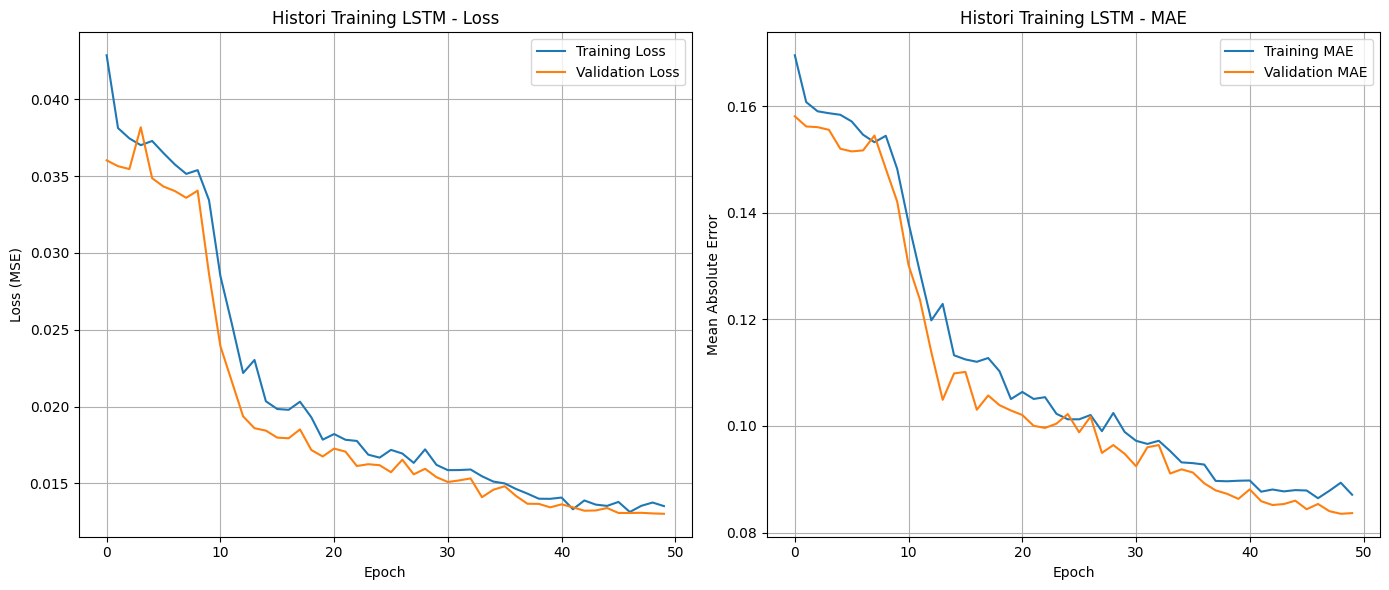

In [ ]:
# --- Cell 6 Training Model dan Menampilkan Summary Setelah Fit ===

if model_lstm_built and lstm_model_instance is not None:
    print("\nModel LSTM berhasil dibangun.")

    NUM_EPOCHS_LSTM = 50  # Definisikan jumlah epoch yang diinginkan
    BATCH_SIZE_LSTM = 64  # Definisikan batch size yang diinginkan

    # Update parameter batch_size dan epochs di TrainingLogger jika ada
    if callbacks_for_lstm_training:
        for cb in callbacks_for_lstm_training:
            if isinstance(cb, TrainingLogger): # Jika ini adalah instance TrainingLogger kita
                cb.batch_size_config = BATCH_SIZE_LSTM
                cb.epochs_config = NUM_EPOCHS_LSTM
                print(f"Parameter TrainingLogger diupdate: batch_size={cb.batch_size_config}, epochs={cb.epochs_config}")

    print(f"Memulai training LSTM dengan {NUM_EPOCHS_LSTM} epoch dan batch size {BATCH_SIZE_LSTM}...")
    history_lstm = lstm_model_instance.fit(
        X_train_lstm, y_train_lstm,
        validation_data=(X_val_lstm, y_val_lstm),
        epochs=NUM_EPOCHS_LSTM,
        batch_size=BATCH_SIZE_LSTM,
        callbacks=callbacks_for_lstm_training,
        verbose=1
    )

    # --- Menampilkan Model Summary SETELAH Training (Model sudah di-build) ---
    print("\n--- Model Summary (Setelah Training) ---")
    lstm_model_instance.summary() # <<<< model.summary() dipindahkan ke sini

    # --- Plot histori training ---
    if history_lstm is not None and history_lstm.history:
        print("\nMembuat plot histori training LSTM...")
        plt.figure(figsize=(14, 6))
        # ... (kode plot loss dan MAE seperti sebelumnya, tidak ada perubahan) ...
        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(history_lstm.history['loss'], label='Training Loss')
        plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
        plt.title('Histori Training LSTM - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)

        # Plot MAE
        plt.subplot(1, 2, 2)
        plt.plot(history_lstm.history['mean_absolute_error'], label='Training MAE')
        plt.plot(history_lstm.history['val_mean_absolute_error'], label='Validation MAE')
        plt.title('Histori Training LSTM - MAE')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("Tidak bisa membuat plot histori karena training LSTM tidak berjalan atau history kosong.")
else:
    print("Tidak bisa memulai training karena model LSTM tidak berhasil dibangun.")


Memulai evaluasi model LSTM pada data test...

Melakukan evaluasi standar model.evaluate()...

Hasil Evaluasi pada Data Test (dari model.evaluate):
- Loss: 0.0106
- Compile Metrics: 0.0761

Contoh Prediksi:
Teks Input (Disingkat)                             | Skor Aktual  | Skor Prediksi 
----------------------------------------------------------------------------------
pertanyaan tanya jelas apa dekat simbolik antropologi... | 0.8700       | 0.8843        
pertanyaan bagaimana ubah iklim global pengaruh distribusi... | 0.7000       | 0.7316        
pertanyaan hukum gravitasi universal guna hitung massa... | 0.5500       | 0.7371        
pertanyaan tanya jelas bagaimana fungsi eksekutif mungkin... | 0.8600       | 0.8855        
pertanyaan apa jadi lama gerhana matahari total... | 0.6000       | 0.7281        

Menghitung semua prediksi untuk metrik evaluasi lanjutan...


===== EVALUASI KINERJA LANJUTAN (METRIK TAMBAHAN) =====

Klasifikasi Biner (Ambang Batas Skor >= 0.6):
  Precision

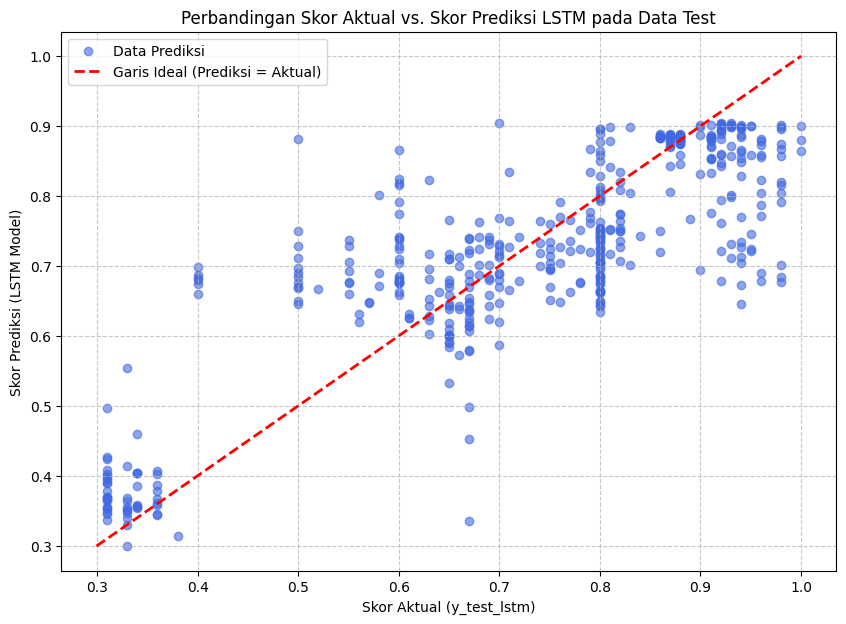

In [ ]:
# --- Cell 7 Evaluasi Model ---

# Impor library yang dibutuhkan jika belum diimpor secara global
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score
from scipy.stats import pearsonr, spearmanr

# Fungsi evaluate_model_extended (definisi dari revisi sebelumnya sudah baik)
def evaluate_model_extended(model_to_eval, X_data, y_data, keras_tokenizer):
    """Evaluasi komprehensif model Keras dan contoh prediksi, termasuk metrik lanjutan."""
    if model_to_eval is None:
        print("Model tidak tersedia untuk dievaluasi.")
        return None, None

    results_from_evaluate = None
    all_predictions_scores = None
    print("\nMelakukan evaluasi standar model.evaluate()...")
    try:
        results_from_evaluate = model_to_eval.evaluate(X_data, y_data, verbose=0)
        print("\nHasil Evaluasi pada Data Test (dari model.evaluate):")
        for metric_name, metric_value in zip(model_to_eval.metrics_names, results_from_evaluate):
            print(f"- {metric_name.replace('_', ' ').title()}: {metric_value:.4f}")
    except Exception as e:
        print(f"Error saat evaluasi model (model.evaluate): {e}")

    if results_from_evaluate is not None:
        num_samples_to_show = min(5, len(X_data))
        if len(X_data) > 0:
            sample_indices = np.random.choice(len(X_data), num_samples_to_show, replace=False)
            print("\nContoh Prediksi:")
            header = f"{'Teks Input (Disingkat)':<50} | {'Skor Aktual':<12} | {'Skor Prediksi':<14}"
            print(header)
            print("-" * len(header))

            sample_X_data = X_data[sample_indices]
            sample_y_data = y_data[sample_indices]
            try:
                sample_preds = model_to_eval.predict(sample_X_data, verbose=0)
                for i, original_idx in enumerate(sample_indices):
                    text_display = f"Sequence {original_idx}..."
                    if keras_tokenizer is not None:
                        original_sequence = [X_data[original_idx]]
                        reconstructed_words = keras_tokenizer.sequences_to_texts(original_sequence)[0].split()
                        text_display = ' '.join(reconstructed_words[:7]) + "..." if len(reconstructed_words) > 7 else ' '.join(reconstructed_words)

                    actual_score = sample_y_data[i]
                    predicted_score = sample_preds[i][0]
                    print(f"{text_display:<50} | {actual_score:<12.4f} | {predicted_score:<14.4f}")
            except Exception as e:
                print(f"Error saat membuat prediksi contoh: {e}")
        else:
            print("Tidak ada data test untuk menampilkan contoh prediksi.")

        print("\nMenghitung semua prediksi untuk metrik evaluasi lanjutan...")
        try:
            all_predictions_scores = model_to_eval.predict(X_data, verbose=0).flatten()
            y_true_scores_eval = y_data

            print("\n\n===== EVALUASI KINERJA LANJUTAN (METRIK TAMBAHAN) =====")
            if len(y_true_scores_eval) == len(all_predictions_scores):
                binary_threshold = 0.6
                def to_multiclass_categories(score_value):
                    if score_value <= 0.4: return 0
                    elif score_value <= 0.75: return 1
                    else: return 2

                y_true_binary = [1 if s >= binary_threshold else 0 for s in y_true_scores_eval]
                y_pred_binary = [1 if s >= binary_threshold else 0 for s in all_predictions_scores]
                if len(set(y_true_binary)) > 1 and len(set(y_pred_binary)) > 1:
                    print(f"\nKlasifikasi Biner (Ambang Batas Skor >= {binary_threshold}):")
                    print(f"  Precision: {precision_score(y_true_binary, y_pred_binary, zero_division=0):.4f}")
                    print(f"  Recall: {recall_score(y_true_binary, y_pred_binary, zero_division=0):.4f}")
                    print(f"  F1-Score: {f1_score(y_true_binary, y_pred_binary, zero_division=0):.4f}")
                else:
                    print(f"\nKlasifikasi Biner (Ambang Batas Skor >= {binary_threshold}): Tidak dapat dihitung (kurang dari 2 kelas unik).")

                y_true_multi = [to_multiclass_categories(s) for s in y_true_scores_eval]
                y_pred_multi = [to_multiclass_categories(s) for s in all_predictions_scores]
                if len(set(y_true_multi)) > 1 and len(set(y_pred_multi)) > 1:
                    print(f"\nKlasifikasi Multi-Kelas (0: <=0.4, 1: <=0.75, 2: >0.75):")
                    print(f"  Precision (weighted avg): {precision_score(y_true_multi, y_pred_multi, average='weighted', zero_division=0):.4f}")
                    print(f"  Recall (weighted avg): {recall_score(y_true_multi, y_pred_multi, average='weighted', zero_division=0):.4f}")
                    print(f"  F1-Score (weighted avg): {f1_score(y_true_multi, y_pred_multi, average='weighted', zero_division=0):.4f}")
                    print(f"  Quadratic Weighted Kappa: {cohen_kappa_score(y_true_multi, y_pred_multi, weights='quadratic'):.4f}")
                else:
                    print(f"\nKlasifikasi Multi-Kelas: Tidak dapat dihitung (kurang dari 2 kelas unik).")

                if len(y_true_scores_eval) > 1:
                    pearson_val, _ = pearsonr(y_true_scores_eval, all_predictions_scores)
                    spearman_val, _ = spearmanr(y_true_scores_eval, all_predictions_scores)
                    print(f"\nKorelasi antara Skor Aktual dan Prediksi:")
                    print(f"  Pearson Correlation: {pearson_val:.4f}")
                    print(f"  Spearman Correlation: {spearman_val:.4f}")
                else:
                    print("\nKorelasi: Tidak cukup data untuk menghitung korelasi.")
            else:
                print("Jumlah skor aktual dan prediksi tidak sama, evaluasi lanjutan tidak dapat dilakukan.")
        except Exception as e:
            print(f"Error saat menghitung metrik evaluasi lanjutan: {e}")
            all_predictions_scores = None

    return results_from_evaluate, all_predictions_scores

# --- Pemanggilan Evaluasi ---
if model_lstm_built and lstm_model_instance is not None:
    print("\nMemulai evaluasi model LSTM pada data test...")
    if 'tokenizer_lstm' in locals() and tokenizer_lstm is not None and \
       'X_test_lstm' in locals() and X_test_lstm is not None and \
       'y_test_lstm' in locals() and y_test_lstm is not None:
        evaluation_results, all_test_predictions = evaluate_model_extended(
            lstm_model_instance, X_test_lstm, y_test_lstm, tokenizer_lstm
        )
        if all_test_predictions is not None:
            print("\nMembuat plot Prediksi vs Aktual untuk data test...")
            try:
                plt.figure(figsize=(10, 7))
                plt.scatter(y_test_lstm, all_test_predictions, alpha=0.6, label='Data Prediksi', color='royalblue')
                min_val_plot = min(y_test_lstm.min(), all_test_predictions.min())
                max_val_plot = max(y_test_lstm.max(), all_test_predictions.max())
                plt.plot([min_val_plot, max_val_plot], [min_val_plot, max_val_plot], 'r--', lw=2, label='Garis Ideal (Prediksi = Aktual)')
                plt.xlabel('Skor Aktual (y_test_lstm)')
                plt.ylabel('Skor Prediksi (LSTM Model)')
                plt.title('Perbandingan Skor Aktual vs. Skor Prediksi LSTM pada Data Test')
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.legend()
                plt.show()
            except Exception as e:
                print(f"Error saat membuat plot prediksi vs aktual: {e}")
    else:
        print("Data test (X_test_lstm, y_test_lstm) atau tokenizer_lstm tidak tersedia untuk evaluasi.")
else:
    print("\nModel LSTM tidak tersedia untuk dievaluasi.")

In [ ]:
# --- Cell 8 Penyimpanan Model dan Artifacts ---

if model_lstm_built and lstm_model_instance is not None:
    print("\nMemulai penyimpanan model LSTM dan artifacts terkait...")

    # --- Menyimpan Model LSTM Keras ---
    path_to_save_lstm_model = os.path.join(LSTM_MODEL_DIR, 'final_lstm_model.h5') # Menggunakan LSTM_MODEL_DIR
    try:
        lstm_model_instance.save(path_to_save_lstm_model)
        print(f"- Model LSTM berhasil disimpan di: {path_to_save_lstm_model}")
    except Exception as e:
         print(f"Error saat menyimpan model LSTM: {e}")

    # --- Menyimpan Tokenizer LSTM ---
    path_to_save_tokenizer_lstm = os.path.join(PREPROCESSING_DIR, 'tokenizer_lstm.pkl') # Menggunakan PREPROCESSING_DIR
    if 'tokenizer_lstm' in locals() and tokenizer_lstm is not None:
        try:
            with open(path_to_save_tokenizer_lstm, 'wb') as f:
                pickle.dump(tokenizer_lstm, f)
            print(f"- Tokenizer LSTM berhasil disimpan di: {path_to_save_tokenizer_lstm}")
        except Exception as e:
            print(f"Error saat menyimpan tokenizer LSTM: {e}")
    else:
        print("Objek Tokenizer LSTM (tokenizer_lstm) tidak tersedia untuk disimpan.")

    # --- Menyimpan Metadata Model LSTM ---
    try:
        dim_embedding_lstm = actual_embedding_dim_for_lstm if 'actual_embedding_dim_for_lstm' in locals() and actual_embedding_dim_for_lstm is not None else "N/A"
        metadata_for_lstm_model = {
            'model_type': 'LSTM_Penilaian_Otomatis',
            'keras_vocab_size': min(VOCAB_SIZE, len(tokenizer_lstm.word_index) + 1) if 'tokenizer_lstm' in locals() else VOCAB_SIZE,
            'max_sequence_length': MAX_LENGTH,
            'embedding_dimension_used': dim_embedding_lstm,
            'lstm_units': 256,
            'bidirectional': True,
            'preprocessing_info': {
                'stemmer': 'Sastrawi',
                'stopword_removal': 'Sastrawi',
                'input_text_format': 'PERTANYAAN: [teks] JAWABAN: [teks] KUNCI: [teks]'
            },
            'lstm_training_date': datetime.now().isoformat(),
            'tensorflow_version': tf.__version__ if 'tf' in locals() else 'N/A',
            'catatan': 'Model LSTM untuk penilaian jawaban esai. Bobot embedding di-freeze.'
        }
        # Menyimpan ke 04_LSTM_Model/model_metadata.json (sesuai file yang Anda temukan)
        path_to_save_metadata_lstm = os.path.join(LSTM_MODEL_DIR, 'model_metadata.json')

        with open(path_to_save_metadata_lstm, 'w') as f:
            json.dump(metadata_for_lstm_model, f, indent=2)
        print(f"- Metadata Model LSTM berhasil disimpan di: {path_to_save_metadata_lstm}")
    except Exception as e:
         print(f"Error saat menyimpan metadata Model LSTM: {e}")

    print("\nProses penyimpanan model LSTM dan artifacts selesai.")
else:
    print("\nModel LSTM tidak tersedia. Tidak bisa menyimpan model dan artifacts.")


Memulai penyimpanan model LSTM dan artifacts terkait...
- Model LSTM berhasil disimpan di: /content/drive/MyDrive/Model/04_LSTM_Model/final_lstm_model.h5
- Tokenizer LSTM berhasil disimpan di: /content/drive/MyDrive/Model/02_Preprocessing_Artifacts/tokenizer_lstm.pkl
- Metadata Model LSTM berhasil disimpan di: /content/drive/MyDrive/Model/04_LSTM_Model/model_metadata.json

Proses penyimpanan model LSTM dan artifacts selesai.


# **4. IMPLEMENTASI ALGORTIMA PENILAIAN**

---



In [8]:
# Pemuatan Model Embedding untuk Evaluasi

# Path ke file KeyedVectors terbaik hasil fine-tuning
# Struktur Anda: 03_Word_Embeddings/Fine_Tuned/embedding_best_kv/glove_best_similarity_keyedvectors.kv
path_to_best_keyed_vectors = os.path.join(EMBEDDING_BEST_KV_SUBDIR, 'glove_best_similarity_keyedvectors.kv')

print(f"Mencoba memuat model KeyedVectors (untuk evaluasi similarity) dari: {path_to_best_keyed_vectors}")
try:
    # Variabel ini akan digunakan oleh fungsi text_to_vector di sel berikutnya
    embedding_model_for_similarity = KeyedVectors.load(path_to_best_keyed_vectors)
    print(f"Model KeyedVectors (bernama 'glove_best_similarity_keyedvectors.kv') berhasil dimuat.")
    print(f"  Dimensi vektor: {embedding_model_for_similarity.vector_size}")
    print(f"  Ukuran vocabulary: {len(embedding_model_for_similarity.key_to_index)}")
except FileNotFoundError:
    print(f"Error: File KeyedVectors tidak ditemukan di {path_to_best_keyed_vectors}")
    print("Pastikan proses fine-tuning embedding di Grup 2 berjalan dan menyimpan output dengan benar.")
    embedding_model_for_similarity = None
except Exception as e:
    print(f"Error saat memuat model KeyedVectors: {e}")
    embedding_model_for_similarity = None

Mencoba memuat model KeyedVectors (untuk evaluasi similarity) dari: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_best_kv/glove_best_similarity_keyedvectors.kv
Model KeyedVectors (bernama 'glove_best_similarity_keyedvectors.kv') berhasil dimuat.
  Dimensi vektor: 300
  Ukuran vocabulary: 3059


In [9]:
# Implementasi Rouge Score

def rouge_score(reference_text, student_text):
    """
    Menghitung ROUGE-1 F1-score antara teks referensi dan teks siswa.
    ROUGE-1 mengukur overlap unigram (kata tunggal).
    """
    # Preprocess kedua teks untuk mendapatkan daftar token yang bersih
    ref_words = preprocess_text(str(reference_text)) # Pastikan input adalah string
    stu_words = preprocess_text(str(student_text))   # Pastikan input adalah string

    # Jika salah satu teks kosong setelah preprocessing, ROUGE score adalah 0
    if not ref_words or not stu_words:
        return 0.0

    # Temukan kata-kata yang sama (common unigrams)
    common_unigrams = set(ref_words) & set(stu_words)

    # Hitung recall: (jumlah kata sama) / (jumlah kata di referensi)
    recall = len(common_unigrams) / len(ref_words)
    # Hitung precision: (jumlah kata sama) / (jumlah kata di jawaban siswa)
    precision = len(common_unigrams) / len(stu_words)

    # Hitung F1-score (harmonic mean dari precision dan recall)
    if (recall + precision) == 0:
        return 0.0 # Hindari pembagian dengan nol jika precision dan recall keduanya 0
    f1_score_rouge = 2 * (recall * precision) / (recall + precision)

    return f1_score_rouge

print("Fungsi rouge_score telah didefinisikan.")

Fungsi rouge_score telah didefinisikan.


In [10]:
# Implementasi TF-IDF Similarity

def tfidf_similarity(reference_text, student_text, context_docs=None):
    """
    Menghitung kemiripan kosinus TF-IDF antara teks referensi dan jawaban siswa.
    'context_docs' adalah list of strings (dokumen) untuk menghitung IDF.
    Jika context_docs tidak diberikan, IDF akan kurang bermakna (atau bisa di-default).
    """
    ref_words = preprocess_text(str(reference_text))
    stu_words = preprocess_text(str(student_text))

    if not ref_words or not stu_words:
        return 0.0

    # Gabungkan semua kata unik dari referensi dan jawaban siswa untuk membentuk vocabulary TF-IDF
    vocabulary = set(ref_words) | set(stu_words)

    # --- Perhitungan Term Frequency (TF) ---
    tf_ref = defaultdict(int)
    for word in ref_words:
        tf_ref[word] += 1

    tf_stu = defaultdict(int)
    for word in stu_words:
        tf_stu[word] += 1

    # --- Perhitungan Inverse Document Frequency (IDF) ---
    idf = defaultdict(float)
    # Jumlah total dokumen dalam konteks. Jika tidak ada konteks, IDF akan tinggi untuk semua kata.
    num_docs_in_context = 0
    processed_context_docs = []

    if context_docs and isinstance(context_docs, list):
        num_docs_in_context = len(context_docs)
        # Preprocess semua dokumen dalam konteks sekali saja
        processed_context_docs = [set(preprocess_text(str(doc))) for doc in context_docs]

    if num_docs_in_context == 0:
        # Jika tidak ada konteks, IDF bisa di-default ke 1 (atau log(1)=0),
        # atau perlakukan setiap kata seolah-olah muncul di 1 dokumen "imajiner"
        # agar tidak semua IDF jadi nol.
        # Untuk saat ini, jika tidak ada konteks, IDF akan membuat kata yang langka di ref/stu jadi penting.
        print("Peringatan TF-IDF: Tidak ada 'context_docs' yang valid diberikan. Skor IDF mungkin kurang representatif.")
        # Menggunakan smoothing sederhana jika tidak ada konteks
        for word in vocabulary:
            idf[word] = 1.0 # Default IDF jika tidak ada konteks
    else:
        for word in vocabulary:
            docs_containing_word = 0
            for processed_doc_set in processed_context_docs:
                if word in processed_doc_set:
                    docs_containing_word += 1
            # Rumus IDF standar dengan smoothing untuk menghindari pembagian dengan nol
            idf[word] = math.log((num_docs_in_context + 1) / (docs_containing_word + 1)) + 1 # Tambah 1 agar tidak negatif

    # --- Membuat Vektor TF-IDF ---
    # Urutkan vocabulary untuk memastikan urutan yang konsisten dalam vektor
    sorted_vocabulary = sorted(list(vocabulary))

    tfidf_vector_ref = np.array([ (tf_ref[word] / len(ref_words)) * idf[word] for word in sorted_vocabulary ]) if ref_words else np.zeros(len(sorted_vocabulary))
    tfidf_vector_stu = np.array([ (tf_stu[word] / len(stu_words)) * idf[word] for word in sorted_vocabulary ]) if stu_words else np.zeros(len(sorted_vocabulary))

    # Hitung cosine similarity antara dua vektor TF-IDF
    return calculate_cosine_similarity(tfidf_vector_ref, tfidf_vector_stu) # Menggunakan fungsi dari sel berikutnya

print("Fungsi tfidf_similarity telah didefinisikan.")

Fungsi tfidf_similarity telah didefinisikan.


In [11]:
# Implementasi Cosine Similarity antar Vektor

def cosine_similarity(vec1, vec2):
    """Menghitung cosine similarity antara dua vektor numpy."""
    # Pastikan input adalah numpy array dan memiliki ukuran > 0
    if not isinstance(vec1, np.ndarray) or not isinstance(vec2, np.ndarray) or vec1.size == 0 or vec2.size == 0:
        return 0.0

    # Pastikan vektor sudah 1D (flatten jika tidak)
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()

    # Hitung dot product
    dot = np.dot(vec1, vec2)

    # Hitung norma (magnitude)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    # Hindari pembagian dengan nol
    if norm1 == 0 or norm2 == 0:
        return 0.0

    # Hitung dan kembalikan cosine similarity
    return dot / (norm1 * norm2)

print("Fungsi cosine_similarity (untuk vektor) telah didefinisikan.")

Fungsi cosine_similarity (untuk vektor) telah didefinisikan.


In [12]:
# Fungsi text_to_vector menggunakan KeyedVectors

def text_to_vector(text_input, keyed_vectors_model, default_vector_value=None): # Parameter ini penting
    """
    Mengonversi teks yang sudah diproses menjadi vektor rata-rata
    menggunakan model KeyedVectors yang diberikan.
    Akan menggunakan default_vector_value jika tidak ada kata yang ditemukan atau input tidak valid.
    """
    # Pastikan model KeyedVectors valid dan memiliki vector_size
    if keyed_vectors_model is None or not hasattr(keyed_vectors_model, 'vector_size'):
        print("  Peringatan (text_to_vector): Model KeyedVectors tidak valid atau tidak dimuat.")
        return default_vector_value.copy() if default_vector_value is not None else np.array([])

    if not isinstance(text_input, str): # Pastikan teks input adalah string
        if default_vector_value is not None: return default_vector_value.copy()
        return np.zeros(keyed_vectors_model.vector_size)

    if not text_input.strip(): # Jika teks input hanya spasi atau kosong
        if default_vector_value is not None: return default_vector_value.copy()
        return np.zeros(keyed_vectors_model.vector_size)

    words = preprocess_text(text_input) # Preprocess teks input

    word_vectors_list = []
    if words:
        for word in words:
            if word in keyed_vectors_model:
                word_vectors_list.append(keyed_vectors_model[word])

    if not word_vectors_list:
        if default_vector_value is not None: return default_vector_value.copy()
        return np.zeros(keyed_vectors_model.vector_size)

    return np.mean(word_vectors_list, axis=0)

print("Fungsi text_to_vector (untuk KeyedVectors dengan default_vector_value) telah didefinisikan (VERSI TERBARU).")

# Contoh penggunaan (opsional, untuk pengujian):
# if 'embedding_model_for_similarity' in locals() and embedding_model_for_similarity is not None:
#     contoh_vektor = text_to_vector("ini adalah contoh kalimat", embedding_model_for_similarity)
#     print(f"\nContoh vektor untuk 'ini adalah contoh kalimat': {contoh_vektor[:5]}...") # Cetak 5 elemen pertama
# else:
#     print("\nTidak dapat menjalankan contoh text_to_vector karena embedding_model_for_similarity tidak dimuat.")

Fungsi text_to_vector (untuk KeyedVectors dengan default_vector_value) telah didefinisikan (VERSI TERBARU).


# **5. INPUT DATA DAN EVALUASI**

---



## **5.1 Persiapan Komponen Evaluasi Akhir**

---



In [13]:
# Cell 1 Pemuatan Model dan Artifacts untuk Evaluasi Akhir

# 1. Memuat Model Embedding (KeyedVectors terbaik hasil fine-tuning) - Opsional jika hanya menggunakan pretrained besar untuk cosine
path_best_keyed_vectors = os.path.join(EMBEDDING_BEST_KV_SUBDIR, 'glove_best_similarity_keyedvectors.kv')
try:
    embedding_model_finetuned_kv_eval = KeyedVectors.load(path_best_keyed_vectors)
    print(f"Model Embedding Fine-tuned (KeyedVectors) berhasil dimuat dari: {path_best_keyed_vectors}")
    print(f"  Dimensi vektor: {embedding_model_finetuned_kv_eval.vector_size}, Vocab: {len(embedding_model_finetuned_kv_eval.key_to_index)}")
except FileNotFoundError:
    print(f"Info: File KeyedVectors fine-tuned '{path_best_keyed_vectors}' tidak ditemukan. Ini opsional jika kita menggunakan pretrained untuk cosine.")
    embedding_model_finetuned_kv_eval = None
except Exception as e:
    print(f"Error saat memuat KeyedVectors fine-tuned dari '{path_best_keyed_vectors}': {e}")
    embedding_model_finetuned_kv_eval = None

# 1.A. MEMUAT MODEL EMBEDDING PRE-TRAINED ASLI (cc.id.300.vec) UNTUK COSINE SIMILARITY
path_pretrained_for_cosine = os.path.join(PRETRAINED_EMBEDDING_DIR, 'cc.id.300.vec')
try:
    embedding_model_large_vocab_eval = KeyedVectors.load_word2vec_format(path_pretrained_for_cosine, binary=False)
    print(f"Model Embedding Pre-trained (untuk Cosine Sim) berhasil dimuat dari: {path_pretrained_for_cosine}")
    print(f"  Dimensi vektor: {embedding_model_large_vocab_eval.vector_size}, Vocab: {len(embedding_model_large_vocab_eval.key_to_index)}")
    if embedding_model_large_vocab_eval.vectors.size > 0:
        mean_vector_for_large_vocab = np.mean(embedding_model_large_vocab_eval.vectors, axis=0)
    else:
        mean_vector_for_large_vocab = np.zeros(embedding_model_large_vocab_eval.vector_size)
    print("  Mean vector untuk model pre-trained (besar) telah dihitung.")
except FileNotFoundError:
    print(f"Error KRUSIAL: File Embedding Pre-trained '{path_pretrained_for_cosine}' TIDAK ditemukan.")
    embedding_model_large_vocab_eval = None
    mean_vector_for_large_vocab = None
except Exception as e:
    print(f"Error saat memuat Embedding Pre-trained dari '{path_pretrained_for_cosine}': {e}")
    embedding_model_large_vocab_eval = None
    mean_vector_for_large_vocab = None

# 2. Memuat Model LSTM yang sudah dilatih
path_lstm_model_eval = os.path.join(LSTM_MODEL_DIR, 'final_lstm_model.h5')
try:
    lstm_model_eval = load_model(path_lstm_model_eval)
    print(f"Model LSTM berhasil dimuat dari: {path_lstm_model_eval}")
except FileNotFoundError:
    print(f"Error KRUSIAL: File model LSTM '{path_lstm_model_eval}' TIDAK ditemukan.")
    lstm_model_eval = None
except Exception as e:
    print(f"Error saat memuat model LSTM dari '{path_lstm_model_eval}': {e}")
    lstm_model_eval = None

# 3. Memuat Tokenizer LSTM
path_tokenizer_eval = os.path.join(PREPROCESSING_DIR, 'tokenizer_lstm.pkl')
try:
    with open(path_tokenizer_eval, 'rb') as f:
        tokenizer_eval = pickle.load(f)
    print(f"Tokenizer LSTM berhasil dimuat dari: {path_tokenizer_eval}")
except FileNotFoundError:
    print(f"Error KRUSIAL: File tokenizer LSTM '{path_tokenizer_eval}' TIDAK ditemukan.")
    tokenizer_eval = None
except Exception as e:
    print(f"Error saat memuat tokenizer LSTM dari '{path_tokenizer_eval}': {e}")
    tokenizer_eval = None

# 4. Mengatur MAX_LENGTH agar konsisten dengan training LSTM
if 'MAX_LENGTH' not in globals():
    MAX_LENGTH_EVAL = 150
    print(f"Peringatan: MAX_LENGTH global tidak ditemukan, menggunakan MAX_LENGTH_EVAL = {MAX_LENGTH_EVAL}")
else:
    MAX_LENGTH_EVAL = MAX_LENGTH
    print(f"Menggunakan MAX_LENGTH (dari training LSTM): {MAX_LENGTH_EVAL}")

# Pengecekan akhir untuk komponen KRUSIAL
if not all([embedding_model_large_vocab_eval, lstm_model_eval, tokenizer_eval, mean_vector_for_large_vocab is not None]):
    print("\nPERINGATAN BESAR: Satu atau lebih komponen KRUSIAL untuk evaluasi gagal dimuat. Harap periksa path dan file.")
else:
    print("\nSemua model dan tokenizer krusial untuk evaluasi akhir berhasil dimuat dan siap digunakan.")

Model Embedding Fine-tuned (KeyedVectors) berhasil dimuat dari: /content/drive/MyDrive/Model/03_Word_Embeddings/Fine_Tuned/embedding_best_kv/glove_best_similarity_keyedvectors.kv
  Dimensi vektor: 300, Vocab: 3059
Model Embedding Pre-trained (untuk Cosine Sim) berhasil dimuat dari: /content/drive/MyDrive/Model/03_Word_Embeddings/Pretrained/cc.id.300.vec
  Dimensi vektor: 300, Vocab: 2000000
  Mean vector untuk model pre-trained (besar) telah dihitung.


Model LSTM berhasil dimuat dari: /content/drive/MyDrive/Model/04_LSTM_Model/final_lstm_model.h5
Tokenizer LSTM berhasil dimuat dari: /content/drive/MyDrive/Model/02_Preprocessing_Artifacts/tokenizer_lstm.pkl
Peringatan: MAX_LENGTH global tidak ditemukan, menggunakan MAX_LENGTH_EVAL = 150

Semua model dan tokenizer krusial untuk evaluasi akhir berhasil dimuat dan siap digunakan.


## **5.2 Evaluasi**

---



In [63]:
# Cell 2 (Grup 5 - Definisi Fungsi evaluate_answer - DENGAN DUA THRESHOLD SCALING)

print("\n--- Tahap 2 (Grup 5): Mendefinisikan Fungsi evaluate_answer (versi Dua Threshold Scaling) ---")

def evaluate_answer(jawaban_siswa_text, soal_text, kata_kunci_list,
                    embedding_model_for_cosine,
                    mean_vector_for_cosine,
                    lstm_model_param,
                    keras_tokenizer_param,
                    max_len_param):
    """
    Mengevaluasi jawaban siswa dengan bobot dinamis dan dua kemungkinan threshold scaling.
    """
    if not all([embedding_model_for_cosine, lstm_model_param, keras_tokenizer_param, mean_vector_for_cosine is not None]):
        print("  Peringatan di evaluate_answer: Model/tokenizer/mean_vector penting tidak valid. Mengembalikan skor 0.")
        return 0.0

    reference_text_for_metrics = str(soal_text)

    # 1. Hitung Skor ROUGE
    skor_rouge = rouge_score(reference_text_for_metrics, str(jawaban_siswa_text))

    # 2. Hitung Skor TF-IDF
    context_for_tfidf = [reference_text_for_metrics] + [str(kw) for kw in kata_kunci_list]
    skor_tfidf = tfidf_similarity(reference_text_for_metrics, str(jawaban_siswa_text), context_docs=context_for_tfidf)

    # 3. Hitung Skor Cosine Embedding
    vector_jawaban = text_to_vector(str(jawaban_siswa_text), embedding_model_for_cosine, default_vector_value=mean_vector_for_cosine)
    vector_ref_cosine = text_to_vector(reference_text_for_metrics, embedding_model_for_cosine, default_vector_value=mean_vector_for_cosine)
    skor_cosine_embedding = calculate_cosine_similarity(vector_jawaban, vector_ref_cosine)

    # 4. Dapatkan Skor dari Model LSTM
    processed_jawaban_for_lstm = preprocess_text(str(jawaban_siswa_text))
    skor_lstm_pred = 0.0
    if not processed_jawaban_for_lstm:
        print("  Peringatan: Jawaban siswa kosong setelah preprocessing. Skor LSTM diatur ke 0.")
        pass
    else:
        try:
            sequence_lstm_input = keras_tokenizer_param.texts_to_sequences([" ".join(processed_jawaban_for_lstm)])
            padded_sequence_lstm_input = pad_sequences(sequence_lstm_input, maxlen=max_len_param, padding='post', truncating='post')
            skor_lstm_pred = lstm_model_param.predict(padded_sequence_lstm_input, verbose=0)[0][0]
        except Exception as e:
            print(f"  Error saat prediksi LSTM: {e}. Skor LSTM diatur ke 0.")
            skor_lstm_pred = 0.0

    # --- Logika Pembobotan Dinamis (Bobot terakhir yang Anda gunakan) ---
    if skor_rouge <= 0.01 and skor_tfidf <= 0.01:
        # Skenario A: ROUGE/TF-IDF sangat rendah
        # print("    Info: Skor ROUGE & TF-IDF sangat rendah. Menggunakan bobot alternatif.")
        bobot_rouge_final = 0.00
        bobot_tfidf_final = 0.00
        bobot_cosine_final = 0.40 # Anda bisa sesuaikan ini jika perlu
        bobot_lstm_final = 0.60   # Anda bisa sesuaikan ini jika perlu
    else:
        # Skenario B: ROUGE atau TF-IDF punya nilai
        # print("    Info: Menggunakan bobot default.")
        bobot_rouge_final = 0.05
        bobot_tfidf_final = 0.05
        bobot_cosine_final = 0.25
        bobot_lstm_final = 0.65

    skor_akhir_gabungan = (skor_rouge * bobot_rouge_final) + \
                          (skor_tfidf * bobot_tfidf_final) + \
                          (skor_cosine_embedding * bobot_cosine_final) + \
                          (skor_lstm_pred * bobot_lstm_final)
    skor_akhir_gabungan = max(0.0, min(1.0, skor_akhir_gabungan))

    skor_sebelum_scaling = skor_akhir_gabungan

    # --- STRATEGI SCALING NON-LINEAR DENGAN DUA KEMUNGKINAN THRESHOLD ---
    skor_setelah_scaling = skor_akhir_gabungan # Inisialisasi

    # Kemungkinan 1: Untuk nilai menengah yang ingin sedikit diangkat
    threshold_scaling_menengah = 0.55
    faktor_angkat_menengah = 0.20 # Sedikit mengangkat (bisa disesuaikan, misal 0.20 atau 0.30)

    # Kemungkinan 2: Untuk nilai tinggi yang ingin diangkat lebih signifikan
    threshold_scaling_tinggi = 0.62 # Skor di atas ini dianggap sudah cukup bagus
    faktor_angkat_tinggi = 0.40   # Mengangkat lebih kuat (bisa disesuaikan, misal 0.35 atau 0.45)

    if skor_akhir_gabungan > threshold_scaling_tinggi:
        # Terapkan scaling untuk nilai tinggi
        sisa_jarak_ke_satu = 1.0 - skor_akhir_gabungan
        penambahan_skor = sisa_jarak_ke_satu * faktor_angkat_tinggi
        skor_setelah_scaling = skor_akhir_gabungan + penambahan_skor
        print(f"    Info Scaling Tinggi: Skor Gab. Awal={skor_sebelum_scaling:.4f} > Thresh={threshold_scaling_tinggi:.2f}. Dinaikkan (Faktor: {faktor_angkat_tinggi:.2f})")
    elif skor_akhir_gabungan > threshold_scaling_menengah:
        # Terapkan scaling untuk nilai menengah
        sisa_jarak_ke_satu = 1.0 - skor_akhir_gabungan
        penambahan_skor = sisa_jarak_ke_satu * faktor_angkat_menengah
        skor_setelah_scaling = skor_akhir_gabungan + penambahan_skor
        print(f"    Info Scaling Menengah: Skor Gab. Awal={skor_sebelum_scaling:.4f} > Thresh={threshold_scaling_menengah:.2f}. Dinaikkan (Faktor: {faktor_angkat_menengah:.2f})")
    # Jika di bawah threshold_scaling_menengah, skor tidak di-scale (skor_setelah_scaling tetap sama dengan skor_akhir_gabungan)

    skor_akhir_final = max(0.0, min(1.0, skor_setelah_scaling)) # Pastikan 0-1 lagi setelah scaling

    print(f"    Detail Skor: ROUGE={skor_rouge:.4f} (B:{bobot_rouge_final:.2f}), "
          f"TF-IDF={skor_tfidf:.4f} (B:{bobot_tfidf_final:.2f}), "
          f"CosEmb={skor_cosine_embedding:.4f} (B:{bobot_cosine_final:.2f}), "
          f"LSTM={skor_lstm_pred:.4f} (B:{bobot_lstm_final:.2f}) -> Gabungan={skor_sebelum_scaling:.4f} -> Scaled Akhir={skor_akhir_final:.4f}")

    return float(skor_akhir_final)

print("Fungsi evaluate_answer (DENGAN DUA THRESHOLD SCALING) telah didefinisikan.")


--- Tahap 2 (Grup 5): Mendefinisikan Fungsi evaluate_answer (versi Dua Threshold Scaling) ---
Fungsi evaluate_answer (DENGAN DUA THRESHOLD SCALING) telah didefinisikan.


In [57]:
# Cell 3 (Grup 5 - Membaca dan Mem-parsing File input_soal.txt - Tanpa Kunci Jawaban Ideal)

print("\n--- Tahap 3 (Grup 5): Mempersiapkan Input dari File .txt ---")

def parse_input_soal_file(file_path):
    """
    Membaca dan mem-parsing file input_soal.txt untuk mendapatkan daftar tugas evaluasi.
    Setiap tugas berisi pertanyaan, jawaban siswa, dan kata kunci (opsional).
    """
    tasks = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
    except FileNotFoundError:
        print(f"  Error: File input soal tidak ditemukan di {file_path}")
        return tasks
    except Exception as e:
        print(f"  Error saat membaca file {file_path}: {e}")
        return tasks

    content_cleaned = re.sub(r'\\\s*', '', content)
    # Memisahkan berdasarkan dua atau lebih baris baru (untuk memisahkan blok soal)
    blocks = re.split(r'\n\s*\n+', content_cleaned.strip())

    for i, block in enumerate(blocks):
        if not block.strip(): # Lewati blok kosong
            continue
        current_task = {
            "id_soal": f"InputFile_{i+1:03d}", # Membuat ID soal otomatis
            "pertanyaan": "",
            # "kunci_jawaban_ideal": "", # Dihilangkan karena tidak ada di input file
            "jawaban_siswa": "",
            "kata_kunci": []     # Default list kosong
        }
        for line in block.strip().split('\n'):
            line = line.strip()
            if line.lower().startswith("pertanyaan:"):
                current_task["pertanyaan"] = line.split(":", 1)[1].strip()
            # Tidak lagi mem-parsing "kunci jawaban ideal:"
            elif line.lower().startswith("jawaban:"):
                current_task["jawaban_siswa"] = line.split(":", 1)[1].strip()
            elif line.lower().startswith("kata kunci:"):
                keywords_str = line.split(":", 1)[1].strip()
                current_task["kata_kunci"] = [kw.strip() for kw in keywords_str.split(',') if kw.strip()]

        # Hanya tambahkan task jika pertanyaan dan jawaban siswa ada (minimal)
        if current_task["pertanyaan"] and current_task["jawaban_siswa"]:
            tasks.append(current_task)
        else:
            print(f"  Peringatan: Blok soal ke-{i+1} di file '{os.path.basename(file_path)}' tidak memiliki 'Pertanyaan:' dan 'Jawaban:' yang valid. Dilewati.")

    return tasks

# Path ke file input_soal.txt Anda
path_input_file_eval = os.path.join(DATASET_DIR, 'input_soal.txt')
print(f"Membaca dan mem-parsing file input: {path_input_file_eval}")

tasks_to_evaluate_final = parse_input_soal_file(path_input_file_eval)

if not tasks_to_evaluate_final:
    print("\nTidak ada tugas evaluasi yang berhasil diparsing. Periksa file input atau path.")
else:
    print(f"\nBerhasil mem-parsing {len(tasks_to_evaluate_final)} tugas evaluasi dari '{os.path.basename(path_input_file_eval)}'.")
    if tasks_to_evaluate_final: # Cetak contoh jika ada tugas
        print("Contoh tugas pertama yang diparsing:")
        print(json.dumps(tasks_to_evaluate_final[0], indent=2, ensure_ascii=False))


--- Tahap 3 (Grup 5): Mempersiapkan Input dari File .txt ---
Membaca dan mem-parsing file input: /content/drive/MyDrive/Model/01_Dataset/input_soal.txt

Berhasil mem-parsing 10 tugas evaluasi dari 'input_soal.txt'.
Contoh tugas pertama yang diparsing:
{
  "id_soal": "InputFile_001",
  "pertanyaan": "Jelaskan secara detail proses siklus karbon di alam!",
  "jawaban_siswa": "Siklus karbon melibatkan perpindahan karbon antara atmosfer, lautan, daratan, dan makhluk hidup. Tumbuhan menyerap CO2 melalui fotosintesis, hewan memakan tumbuhan, dan keduanya melepaskan CO2 melalui respirasi. Dekomposisi organisme mati juga mengembalikan karbon ke tanah dan atmosfer. Aktivitas manusia seperti pembakaran bahan bakar fosil menambah CO2 ke atmosfer secara signifikan.",
  "kata_kunci": [
    "atmosfer",
    "fotosintesis",
    "respirasi",
    "dekomposisi",
    "bahan bakar fosil"
  ]
}


In [64]:
# Cell 4 (Grup 5 - Loop Evaluasi dari Data yang Diparsing dan Penyimpanan Hasil)

print("\n--- Tahap 4 (Grup 5): Memulai Proses Evaluasi Jawaban ---")
hasil_penilaian_akhir = [] # List untuk menyimpan semua hasil

# Pengecekan terakhir sebelum loop evaluasi
if not all([embedding_model_large_vocab_eval, lstm_model_eval, tokenizer_eval,
            mean_vector_for_large_vocab is not None, 'MAX_LENGTH_EVAL' in globals()]):
    print("Evaluasi tidak dapat dilanjutkan karena satu atau lebih komponen penting tidak dimuat/didefinisikan dengan benar.")
elif not tasks_to_evaluate_final: # tasks_to_evaluate_final dari Cell 3 di atas
    print("Tidak ada tugas untuk dievaluasi (data parsing dari file .txt gagal atau file kosong).")
else:
    for i, task_item in enumerate(tasks_to_evaluate_final):
        print(f"\nMengevaluasi Tugas ID: {task_item.get('id_soal', f'Index_{i+1}')}")

        soal_eval = task_item.get("pertanyaan", "")
        jawaban_siswa_eval = task_item.get("jawaban_siswa", "")
        kata_kunci_eval = task_item.get("kata_kunci", [])
        # kunci_jawaban_ideal_eval tidak lagi diambil karena sudah dihapus dari parser

        print(f"  Soal (awal): {soal_eval[:80]}...")

        if not jawaban_siswa_eval.strip():
            print("  Peringatan: Jawaban siswa untuk tugas ini kosong. Skor akan dihitung sebagai 0.")
            skor_final_eval = 0.0
        else:
            # Panggil fungsi evaluate_answer dengan semua parameter yang dibutuhkan
            # Tidak lagi meneruskan kunci_jawaban_ideal_text
            skor_final_eval = evaluate_answer(
                jawaban_siswa_text=jawaban_siswa_eval,
                soal_text=soal_eval,
                kata_kunci_list=kata_kunci_eval,
                embedding_model_for_cosine=embedding_model_large_vocab_eval,
                mean_vector_for_cosine=mean_vector_for_large_vocab,
                lstm_model_param=lstm_model_eval,
                keras_tokenizer_param=tokenizer_eval,
                max_len_param=MAX_LENGTH_EVAL
            )

        hasil_penilaian_akhir.append({
            "id_soal": task_item.get("id_soal", f"Index_{i+1}"),
            "soal": soal_eval,
            "jawaban_siswa_input": jawaban_siswa_eval,
            "kata_kunci_input": kata_kunci_eval,
            "skor_total_numerik": skor_final_eval,
            "skor_total_persen": f"{skor_final_eval * 100:.2f}"
        })
        print(f"  Skor Total Gabungan untuk Tugas '{task_item.get('id_soal', '')}': {skor_final_eval * 100:.2f}/100")

# --- Cetak dan Simpan Hasil Penilaian Akhir ---
print("\n\n===== HASIL PENILAIAN AKHIR (dari input_soal.txt) =====")
if not hasil_penilaian_akhir:
    print("Tidak ada hasil penilaian untuk ditampilkan.")
else:
    try:
        df_hasil = pd.DataFrame(hasil_penilaian_akhir)
        print(df_hasil[['id_soal', 'soal', 'skor_total_persen']].to_string(index=False))
    except Exception as e:
        print(f"Error membuat DataFrame dengan Pandas: {e}. Mencetak hasil secara manual:")
        for hasil_item in hasil_penilaian_akhir:
            print(f"\nID Tugas: {hasil_item['id_soal']}")
            print(f"Soal: {hasil_item['soal']}")
            print(f"Kata Kunci: {', '.join(hasil_item['kata_kunci_input']) if hasil_item['kata_kunci_input'] else '-'}")
            print(f"Skor Total: {hasil_item['skor_total_persen']}/100")
            print("-" * 40)

# Opsional: Menyimpan hasil_penilaian_akhir ke file JSON baru di folder Logs
# path_output_hasil_evaluasi = os.path.join(LOGS_DIR, 'hasil_evaluasi_akhir.json') # Nama file output bisa diubah
# try:
#     with open(path_output_hasil_evaluasi, 'w', encoding='utf-8') as f_out:
#        json.dump(hasil_penilaian_akhir, f_out, indent=2, ensure_ascii=False)
#     print(f"\nHasil penilaian akhir juga disimpan dalam format JSON di: {path_output_hasil_evaluasi}")
# except Exception as e:
#     print(f"Gagal menyimpan hasil penilaian akhir ke JSON: {e}")

print("\n--- Grup 5 Selesai ---")


--- Tahap 4 (Grup 5): Memulai Proses Evaluasi Jawaban ---

Mengevaluasi Tugas ID: InputFile_001
  Soal (awal): Jelaskan secara detail proses siklus karbon di alam!...
    Info Scaling Tinggi: Skor Gab. Awal=0.6695 > Thresh=0.62. Dinaikkan (Faktor: 0.40)
    Detail Skor: ROUGE=0.0870 (B:0.05), TF-IDF=0.1726 (B:0.05), CosEmb=0.7810 (B:0.25), LSTM=0.7097 (B:0.65) -> Gabungan=0.6695 -> Scaled Akhir=0.8017
  Skor Total Gabungan untuk Tugas 'InputFile_001': 80.17/100

Mengevaluasi Tugas ID: InputFile_002
  Soal (awal): Apa saja komponen utama dalam sistem tata surya kita dan sebutkan urutan planet ...
    Info Scaling Menengah: Skor Gab. Awal=0.5772 > Thresh=0.55. Dinaikkan (Faktor: 0.20)
    Detail Skor: ROUGE=0.2581 (B:0.05), TF-IDF=0.2615 (B:0.05), CosEmb=0.7539 (B:0.25), LSTM=0.5580 (B:0.65) -> Gabungan=0.5772 -> Scaled Akhir=0.6617
  Skor Total Gabungan untuk Tugas 'InputFile_002': 66.17/100

Mengevaluasi Tugas ID: InputFile_003
  Soal (awal): Deskripsikan tiga teori utama mengenai asa